In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Ensure matplotlib recognizes date format from Pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.feature_selection import RFE

from Utils.DataAnalysis import WellDataProcessor
from Utils.FeatureEngineering import FeatureTransformer
from sklearn.model_selection import GridSearchCV

import shap
from Utils.SentivityAnalysis import SensitivityAnalysis

### Data overview

- DATE - date of production
- WELLNAME - name of the well
- BHP - bottomhole pressure
- WHP - wellhead pressure
- CHOKE_1_PERC - percentage of the first choke openess
- CHOKE_2_PERC - percentage of the second choke openess
- OIL_PROD - volume of oil production
- GAS_PROD - volume of gas production
- WAT_PROD - volume of water production
- WAT_INJ - volume of injected water
- WELL_TYPE - type of the well (OP - oil production, WI - water injection)

Injection Wells (WI): These are the wells through which water is injected into the reservoir. The data provided usually includes the volume of water injected (WAT_INJ), and if the well is used for injection, its WELL_TYPE would be labeled 'WI'.

Producing Wells (OP): The wells from which oil is extracted are called producing wells. These wells will have a WELL_TYPE labeled 'OP' and will show the volumes of oil (OIL_PROD), gas (GAS_PROD), and water (WAT_PROD) produced.

Bottomhole Pressure (BHP): This is the pressure at the bottom of the well. It's an important indicator of the reservoir's pressure. In a water injection process, maintaining an optimal BHP is critical to ensure that the oil continues to flow towards the production wells.

Wellhead Pressure (WHP): This is the pressure at the top of the well, at the wellhead. The difference between the BHP and the WHP can give insights into the pressure drop along the wellbore and can affect the flow of fluids to the surface.

Choke Settings (CHOKE_1_PERC and CHOKE_2_PERC): A choke is used to control the flow of fluids from the well. The choke settings, given as percentages, indicate how open the chokes are. Adjusting these settings helps manage the production rate and the pressure regime within the reservoir.

**Assumptions**
- Data has correct standard units
- We will have data for prior days in production

**Water injection Method**:

Water is injected into the reservoir through water injection wells. This water pushes the oil towards the production wells and helps maintain the pressure in the reservoir after the natural pressure has declined.

The injection of water leads to an increase in the reservoir's pressure, reducing the viscosity of oil, and improving its ability to flow through the porous rock towards the producing wells.

The injected water eventually arrives at the producing wells, where it is produced along with the oil and gas. The produced water is then separated from the oil and gas at the surface using separators.

After separation, the water may be treated and re-injected into the reservoir, thus creating a cycle that helps in maximizing oil recovery.

## EDA

- I have created a seperate file under utils folder called DataAnalysis to visualise the graph below 

In [2]:
processor = WellDataProcessor('data/prod_data_train.csv')

- the above code preprocess the data

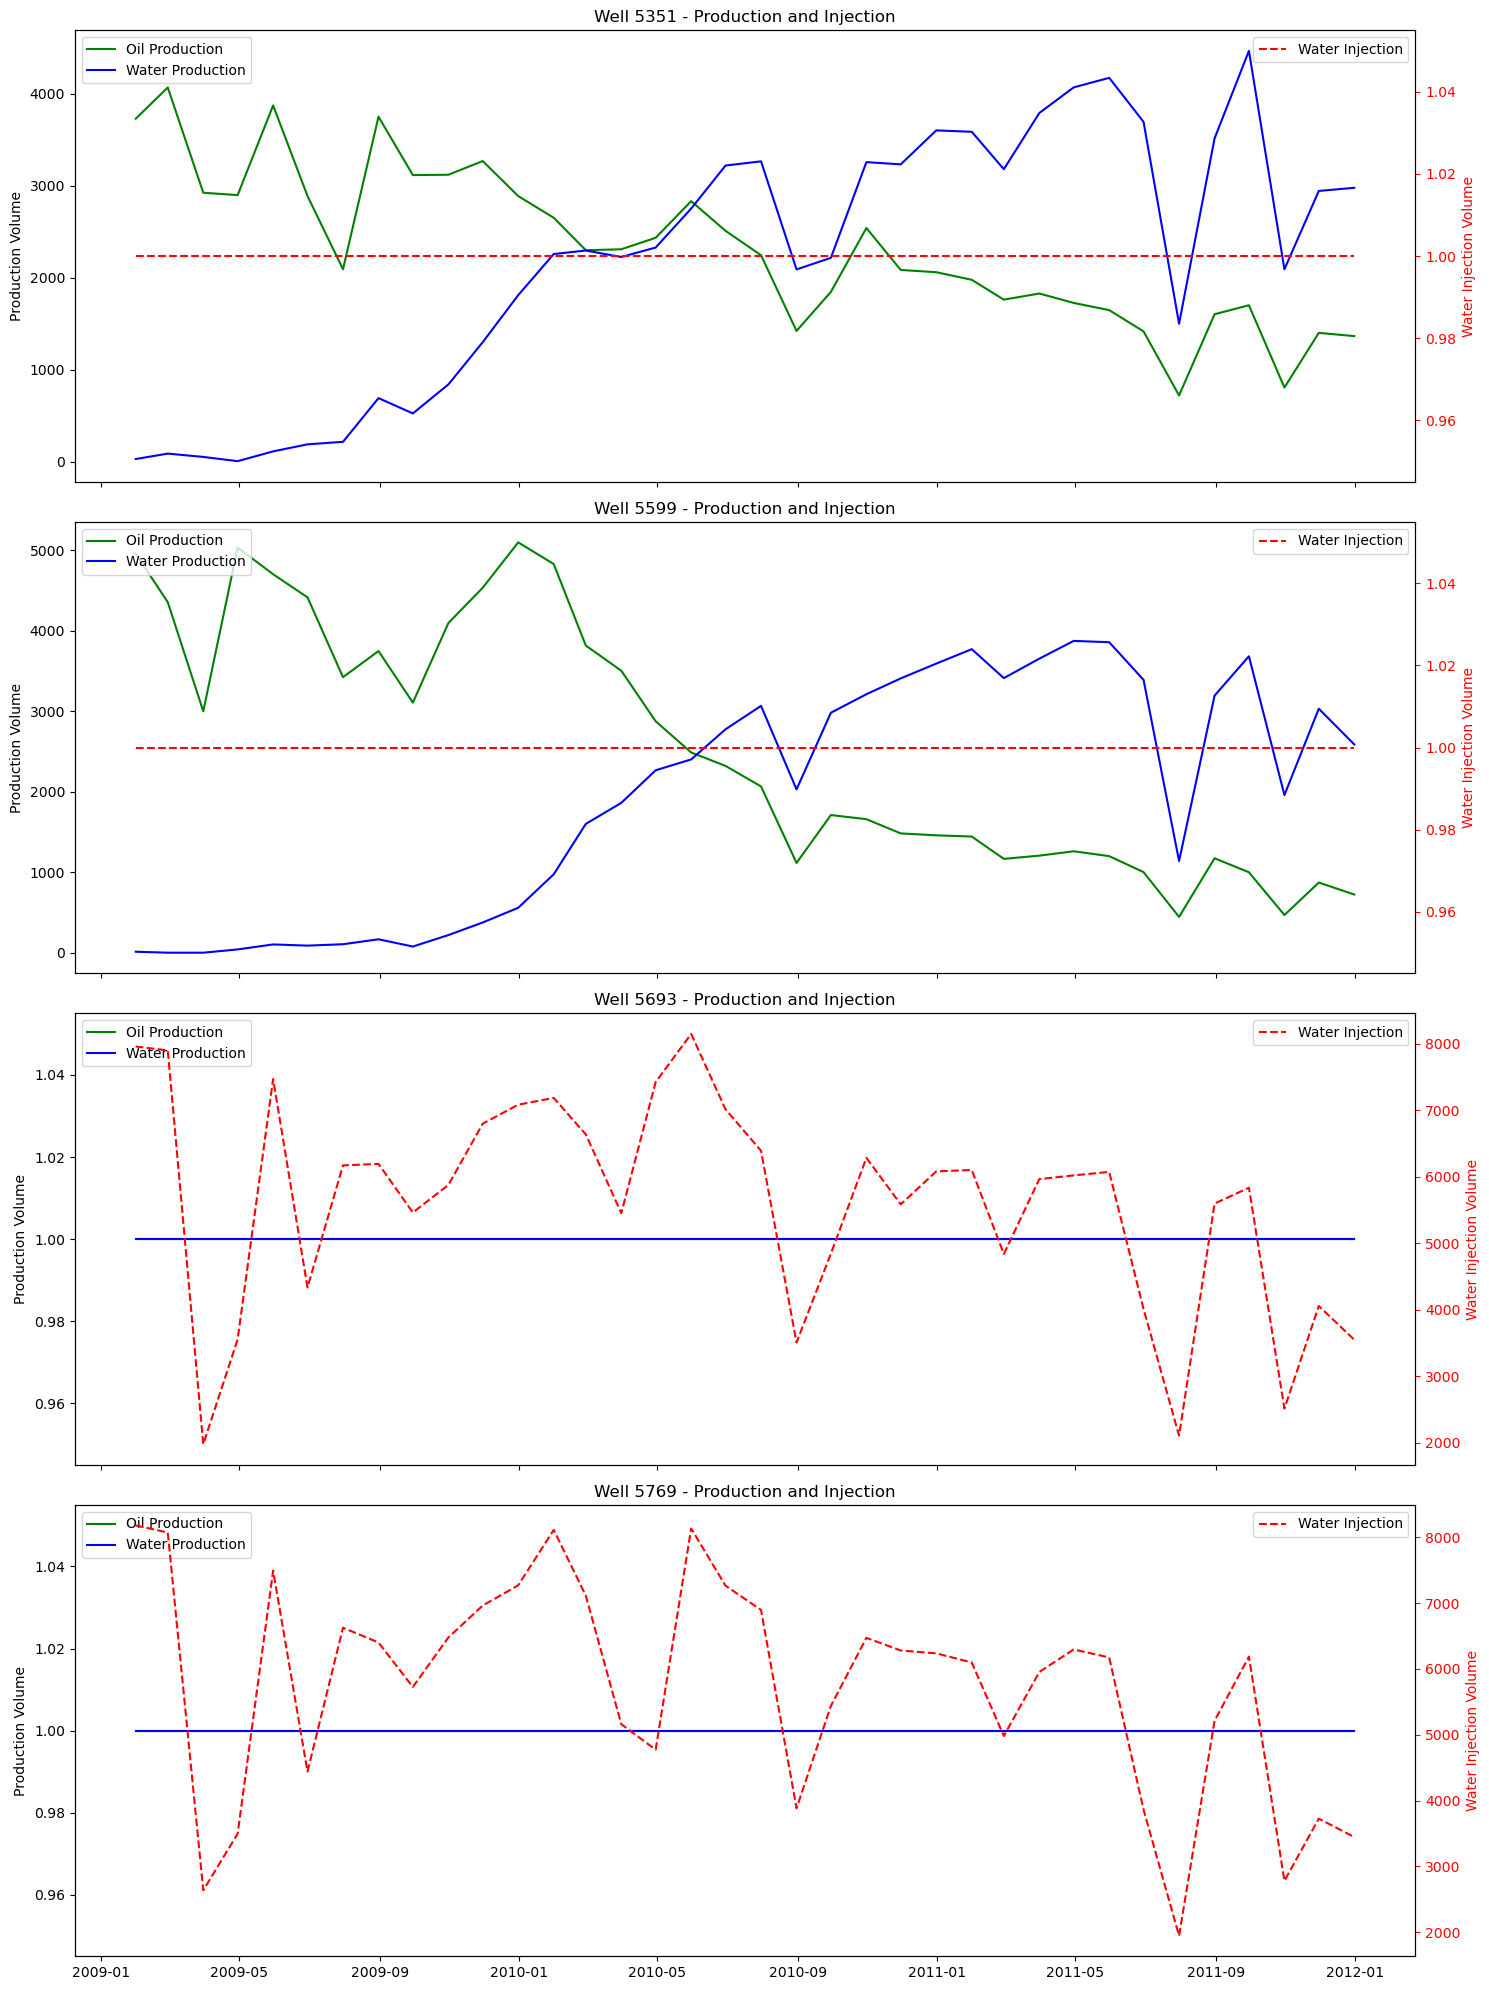

In [3]:
processor.visualize_well_data()

- the graph above provides the visualisation of production volume for injector as well as oil wells over time
- the data had volumes per day, which the above function samples over month and plots it 
- the visualisation falls well in line with the assumption that the volume of oil decreases ovetime whereas the volume of water increases during oil production
- there also seems to be a dip in all wells during september 2010, which could be due to it could be due to operational changes, well interventions, reservoir conditions changing over time, or the implementation of different production strategies.
- we see a simmilar dip during september of 2011.

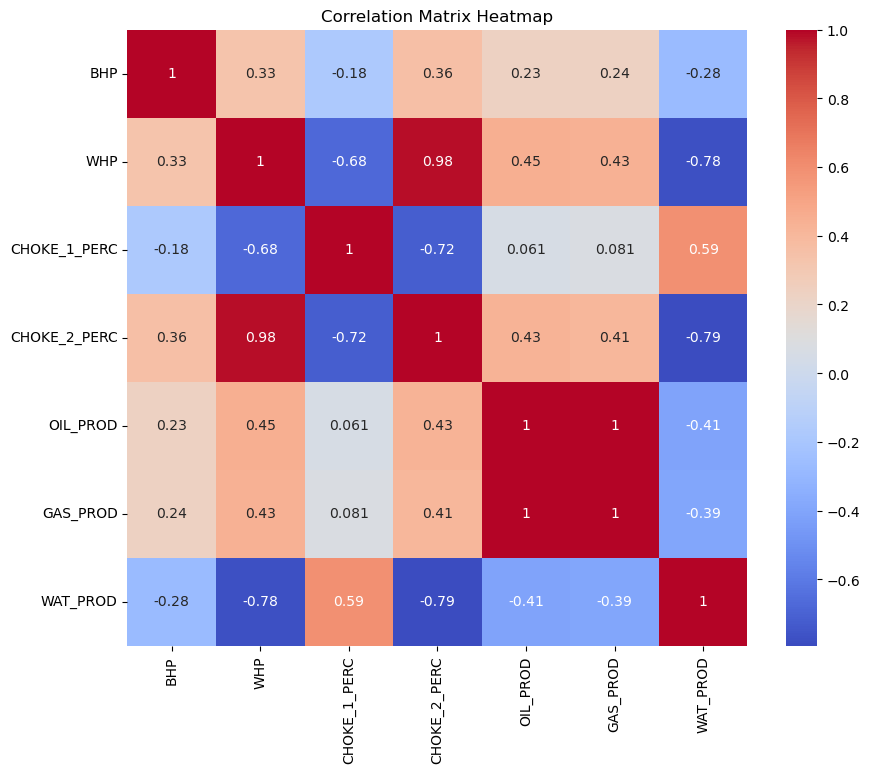

In [4]:
processor.plot_correlation_heatmap()

- the above matrix graph plots the spearmen correlation and measures the level of montonicity between the features

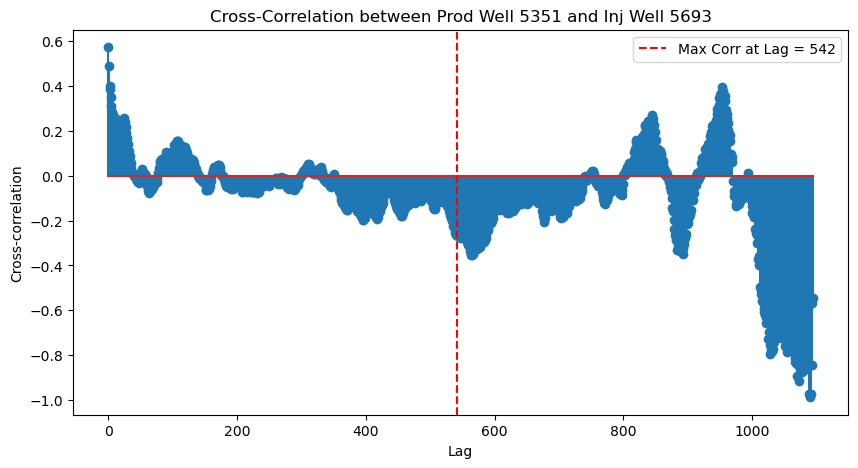

Between Prod Well 5351 and Inj Well 5693, the lag with highest cross-correlation is: 542 days



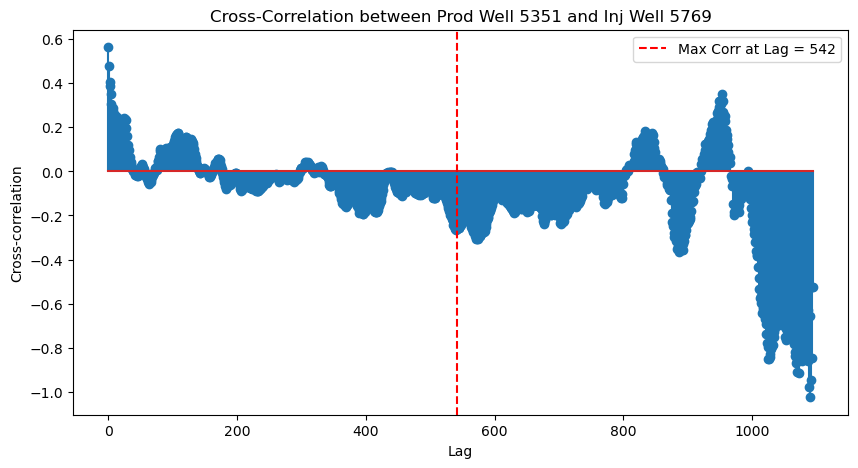

Between Prod Well 5351 and Inj Well 5769, the lag with highest cross-correlation is: 542 days



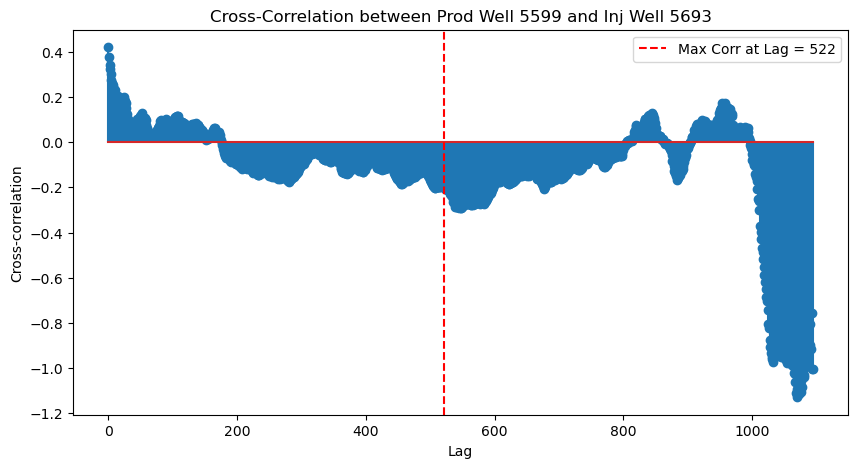

Between Prod Well 5599 and Inj Well 5693, the lag with highest cross-correlation is: 522 days



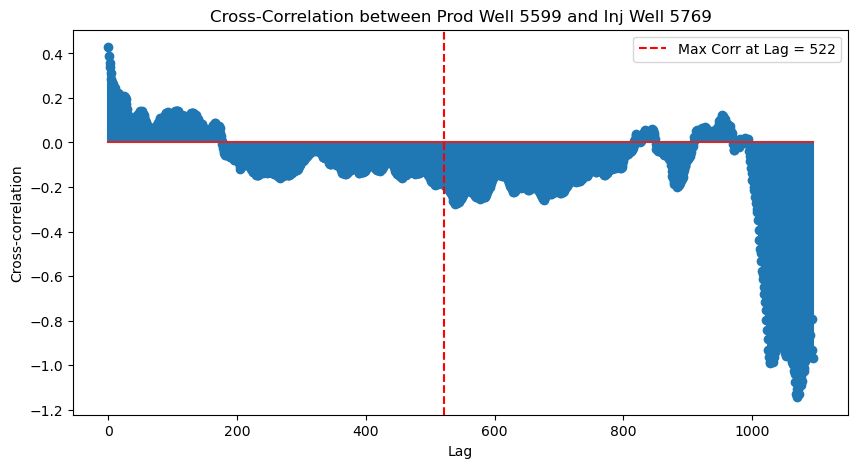

Between Prod Well 5599 and Inj Well 5769, the lag with highest cross-correlation is: 522 days



In [8]:
production_wells = [5351, 5599]
injection_wells = [5693, 5769]
processor.analyze_wells(production_wells, injection_wells)

- The plots show the cross-correlation between the specified oil production and water injection wells. For each pair of wells, the cross-correlation function (CCF) values for oil are plotted against the lag, with the red dashed line indicating the lag where the maximum correlation occurs.
- The red lines have been adjusted to make the lag 0 centered.
- This analysis helps in understanding the temporal relationship between the water injection volumes and oil production amounts, potentially indicating how changes in injection rates might influence oil production at different lags.
- The output of cross-correlation seems to show maximum correlation at around 1 year 5 months, which is also negative with oil production.This could indicate that natural pressure could have declined during this time and water injection could be helpin it produce more

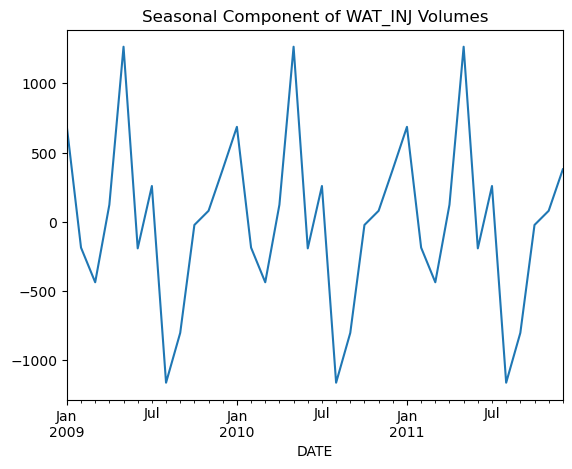

In [9]:
processor.decompose_and_plot_seasonal('WAT_INJ','WI')

- The following code plots seasonal decomposition which helps us Identify Trends between Water Injection and Injection Volumes.
- based on this we can add these as features of low, high and moderate injection months.

In [ ]:
# processor.decompose_and_plot_seasonal('OIL_PROD','OP')
# processor.decompose_and_plot_seasonal('WAT_PROD','OP')

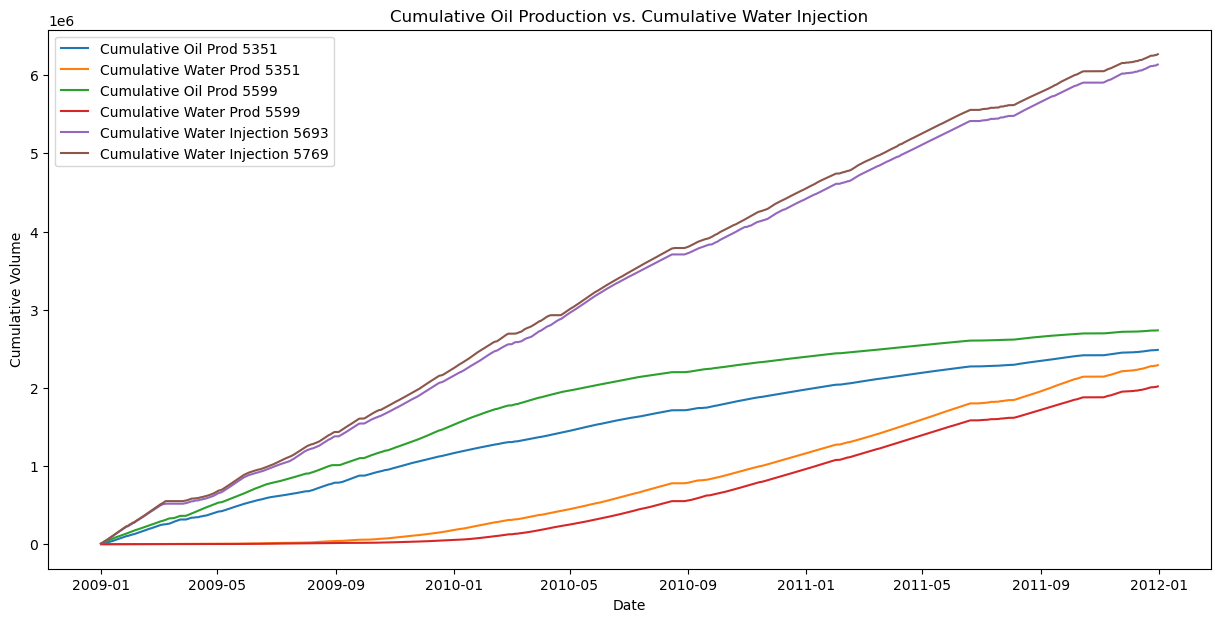

In [12]:
processor.calculate_and_plot_cumulative()

- cumulative volumes are showing a that oil wells are saturating and maybe re-injection processes may be affecting them

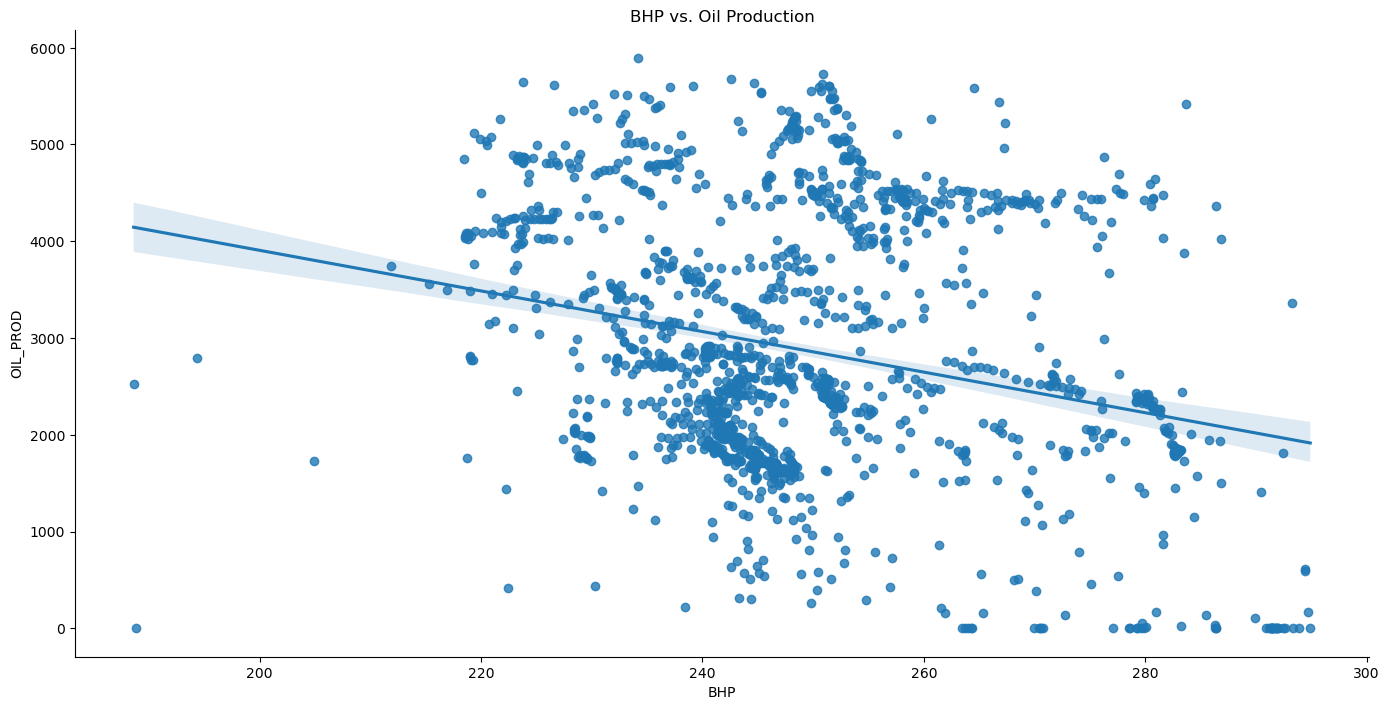

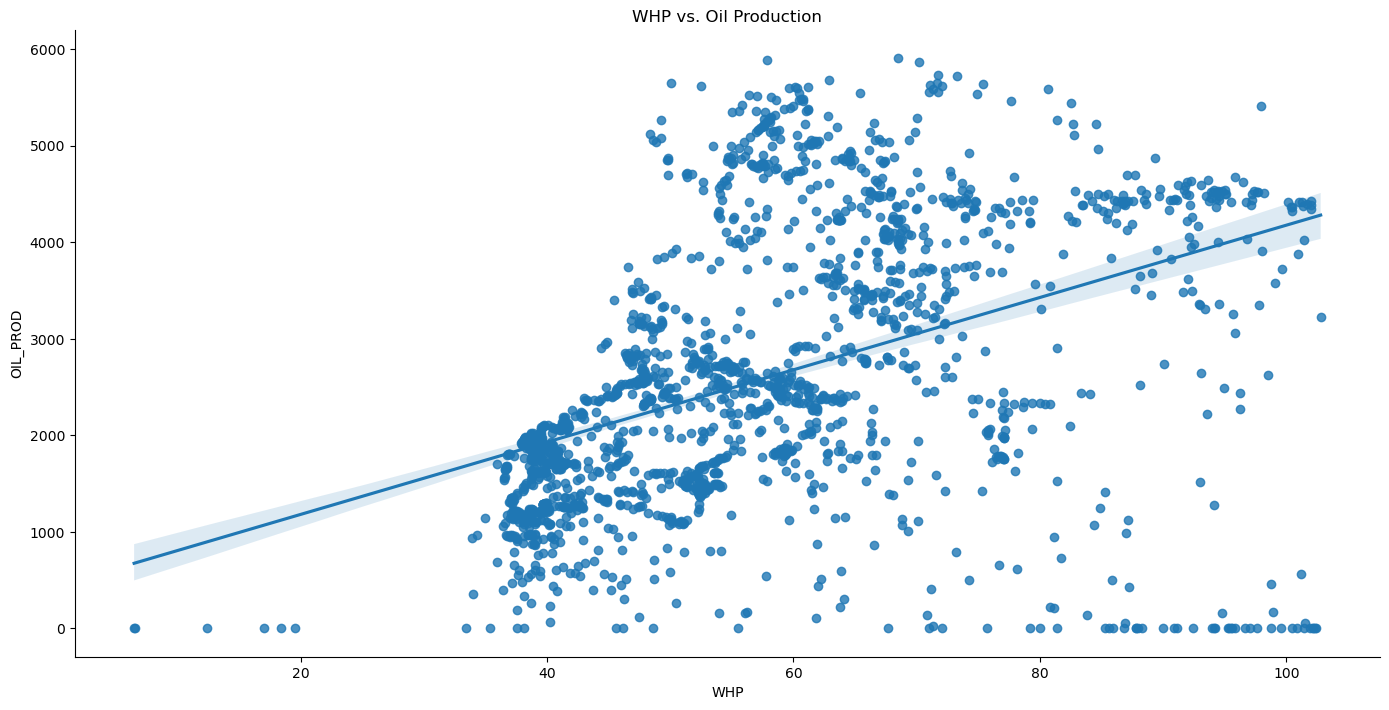

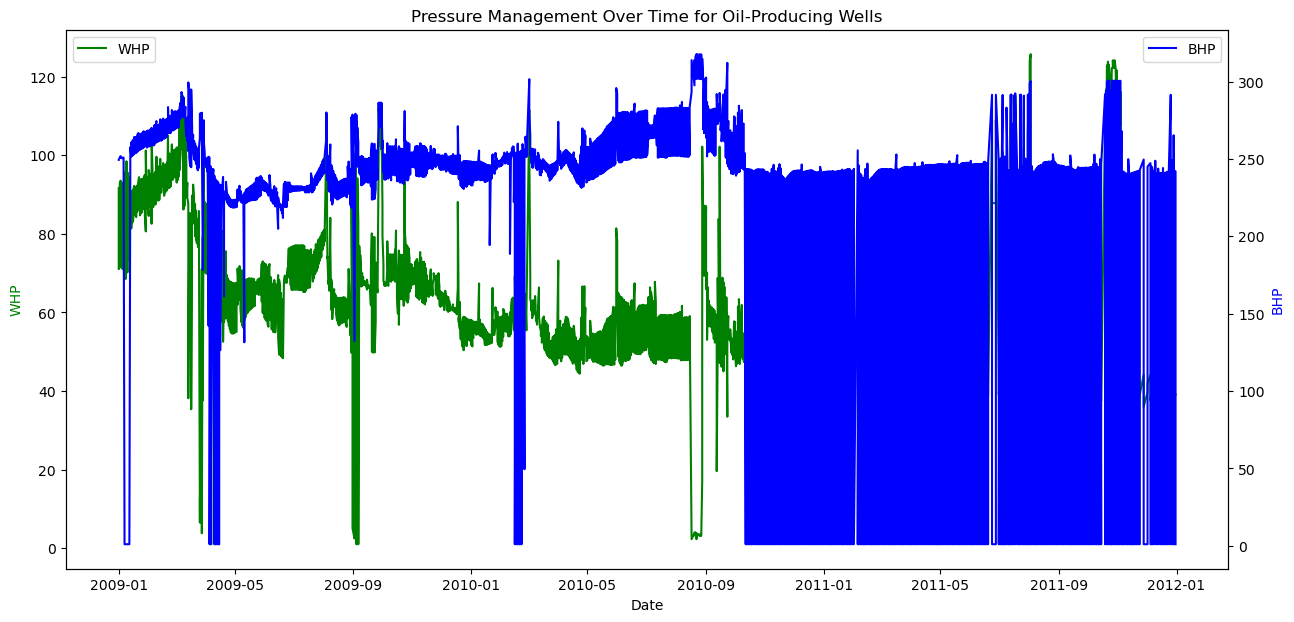

In [13]:
filtered_data_bhp = processor.remove_outliers('BHP')
processor.plot_implot_vs_production(filtered_data_bhp, 'BHP', 'OIL_PROD', 'BHP vs. Oil Production')
filtered_data_whp = processor.remove_outliers('WHP')
processor.plot_implot_vs_production(filtered_data_whp, 'WHP', 'OIL_PROD', 'WHP vs. Oil Production')
processor.plot_pressure_management(processor.oil_data)

- the 1st plot plots an implot between oil produtions and bottomhole and wellhead pressures,the implot is plotted with outliers removed by IQR method
- The second graph plots the
- the values seem to deviate around september of 2010,which could further indicate reservoir conditions changing over time, or the implementation of different production strategies, etc

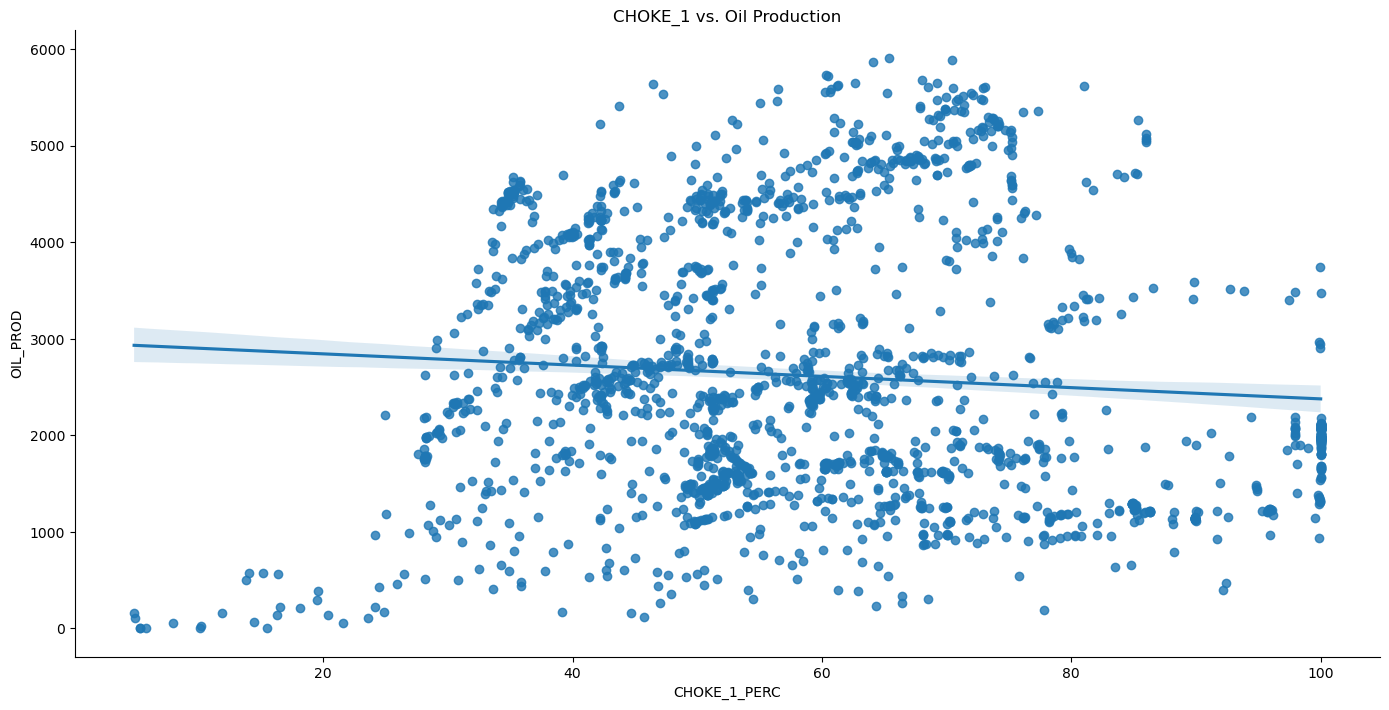

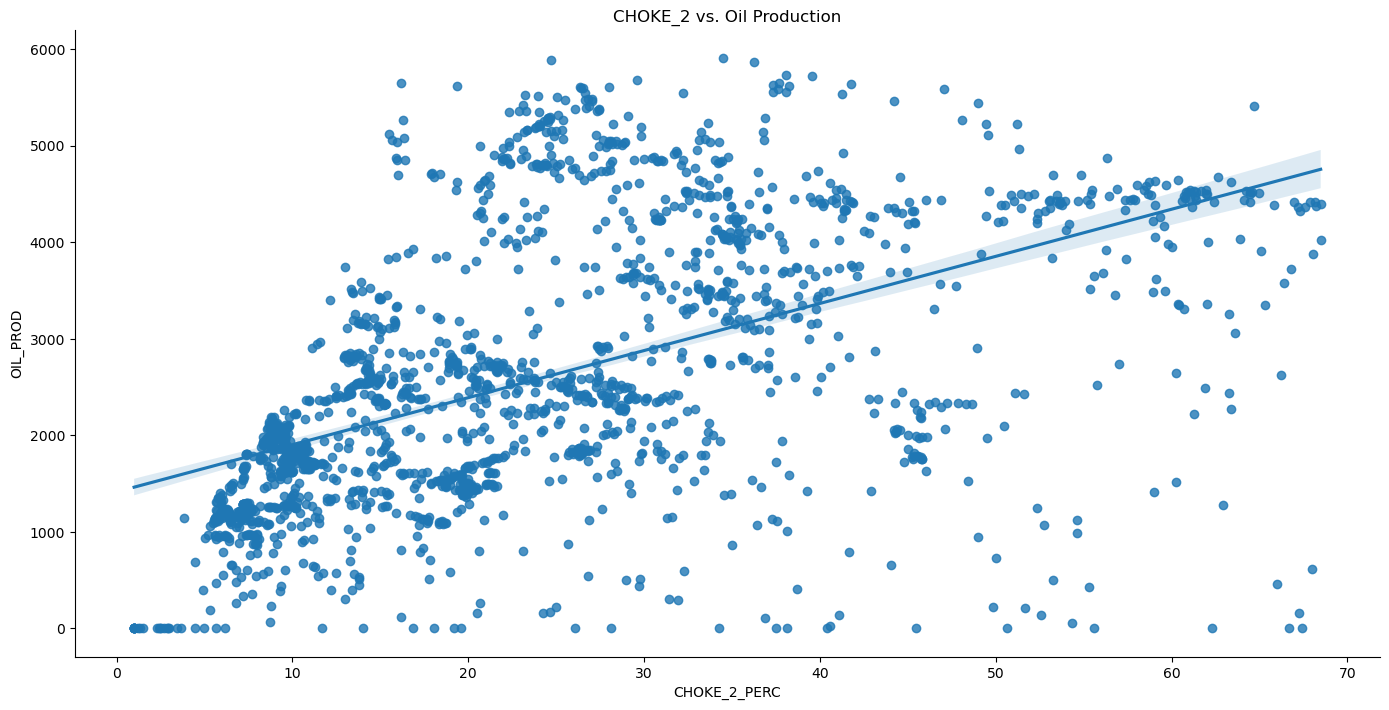

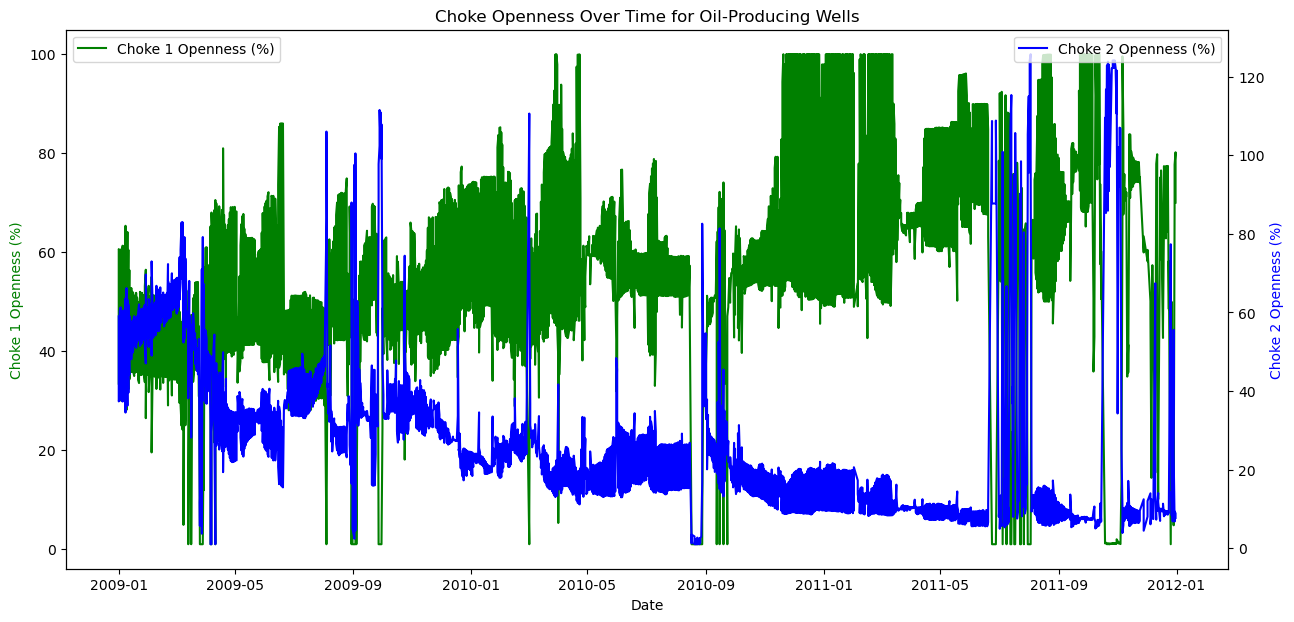

In [14]:
filtered_data_bhp = processor.remove_outliers('CHOKE_1_PERC')
processor.plot_implot_vs_production(filtered_data_bhp, 'CHOKE_1_PERC', 'OIL_PROD', 'CHOKE_1 vs. Oil Production')
filtered_data_bhp = processor.remove_outliers('CHOKE_2_PERC')
processor.plot_implot_vs_production(filtered_data_bhp, 'CHOKE_2_PERC', 'OIL_PROD', 'CHOKE_2 vs. Oil Production')
processor.plot_choke_management(processor.oil_data)

**Potential Ouliers**

In [ ]:
# data[(data.DATE>'2009-10-01') & (data.WELLNAME.isin([5351, 5599]))][['BHP','WHP']].describe()
# data[(data.WELL_TYPE=='OP') & (data.CHOKE_1_PERC == 1) & (data.OIL_PROD>1)]
# data[(data.WELL_TYPE=='OP') & (data.BHP == 1)]
# data[(data.WELL_TYPE=='OP') & (data.WHP == 1) & (data.OIL_PROD>1)]

- there are outliers in the Data example BHP,WHP are 1 at time in the data, this could be due to various reasons(maintance downtime,faulty equipent etc)
- there are times when CHOKE_1_PERC == 1 but too much oil is produced

## Feature engineering

In [16]:
def compute_pressure_features(df):
    # Ensure the new columns exist and are initialized correctly
    if 'BHP_CHANGE_RATE' not in df.columns:
        df['BHP_CHANGE_RATE'] = 0.0
    if 'WHP_Change_Rate' not in df.columns:
        df['WHP_Change_Rate'] = 0.0
    
    # Convert DATE column to datetime if it's not already
    if not np.issubdtype(df['DATE'].dtype, np.datetime64):
        df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Compute features for each well separately
    for well_name in df['WELLNAME'].unique():
        well_filter = (df['WELLNAME'] == well_name) & (df['WELL_TYPE'] == 'OP')
        df.loc[well_filter, 'BHP_CHANGE_RATE'] = df.loc[well_filter, 'BHP'].diff(30) / 30
        df.loc[well_filter, 'WHP_Change_Rate'] = df.loc[well_filter, 'WHP'].diff(30) / 30
    
    df['BHP_CHANGE_RATE'].fillna(0, inplace=True)
    df['WHP_Change_Rate'].fillna(0, inplace=True)
    
    return df
def compute_max_choke_values(df):
    max_choke_1 = df['CHOKE_1_PERC'].max()
    max_choke_2 = df['CHOKE_2_PERC'].max()
    return max_choke_1, max_choke_2
    
def apply_choke_features(df, max_choke_1, max_choke_2):
    df['NORM_CHOKE_1'] = df['CHOKE_1_PERC'] / max_choke_1 if max_choke_1 != 0 else 0
    df['NORM_CHOKE_2'] = df['CHOKE_2_PERC'] / max_choke_2 if max_choke_2 != 0 else 0
    df['CHOKE_INTERACTION'] = df['NORM_CHOKE_1'] * df['NORM_CHOKE_2']
    return df

def compute_cumulative_changes(df):
    if 'CUMULATIVE_BHP_CHANGE' not in df.columns:
        df['CUMULATIVE_BHP_CHANGE'] = 0.0
    if 'CUMULATIVE_WHP_CHANGE' not in df.columns:
        df['CUMULATIVE_WHP_CHANGE'] = 0.0
    
    for well_name in df['WELLNAME'].unique():
        well_filter = (df['WELLNAME'] == well_name) & (df['WELL_TYPE'] == 'OP')
        df.loc[well_filter, 'CUMULATIVE_BHP_CHANGE'] = df.loc[well_filter, 'BHP'].diff(30).cumsum()
        df.loc[well_filter, 'CUMULATIVE_WHP_CHANGE'] = df.loc[well_filter, 'WHP'].diff(30).cumsum()
    
    df['CUMULATIVE_BHP_CHANGE'].fillna(0, inplace=True)
    df['CUMULATIVE_WHP_CHANGE'].fillna(0, inplace=True)
    
    return df

def compute_injection_features(df):
    injection_cols = ['INJ_VOLUME_LAG_542D', 'INJ_VOLUME_LAG_522D', 'INJ_RATE_CHANGE', 
                      'INJ_RATE_CHANGE_LAG_542D', 'INJ_RATE_CHANGE_LAG_522D', 'CUMULATIVE_INJ_VOL']
    for col in injection_cols:
        if col not in df.columns:
            df[col] = 0.0
    
    for well_name in df['WELLNAME'].unique():
        iw_filter = (df['WELLNAME'] == well_name) & (df['WELL_TYPE'] == 'WI')
        df.loc[iw_filter, 'INJ_VOLUME_LAG_542D'] = df.loc[iw_filter, 'WAT_INJ'].shift(542).fillna(0)
        df.loc[iw_filter, 'INJ_VOLUME_LAG_522D'] = df.loc[iw_filter, 'WAT_INJ'].shift(522).fillna(0)
        df.loc[iw_filter, 'INJ_RATE_CHANGE'] = df.loc[iw_filter, 'WAT_INJ'].diff(30).bfill() / 30
        df.loc[iw_filter, 'INJ_RATE_CHANGE_LAG_542D'] = df.loc[iw_filter, 'INJ_RATE_CHANGE'].shift(542).fillna(0)
        df.loc[iw_filter, 'INJ_RATE_CHANGE_LAG_522D'] = df.loc[iw_filter, 'INJ_RATE_CHANGE'].shift(522).fillna(0)
        df.loc[iw_filter, 'CUMULATIVE_INJ_VOL'] = df.loc[iw_filter, 'WAT_INJ'].cumsum()
    
    return df


def compute_seasonal_features(df):
    if not np.issubdtype(df['DATE'].dtype, np.datetime64):
        df['DATE'] = pd.to_datetime(df['DATE'])
    
    if 'INJ_MONTH' not in df.columns:
        df['INJ_MONTH'] = 0
    
    peak_injection_months = [3, 4, 5]
    medium_injection_months = [8, 9, 10, 11, 12, 1]
    low_injection_months = [2, 6, 7]
    
    df['INJ_MONTH'] = np.select(
        [df['DATE'].dt.month.isin(peak_injection_months),
         df['DATE'].dt.month.isin(medium_injection_months),
         df['DATE'].dt.month.isin(low_injection_months)],
        [3, 2, 1], 
        default=0
    )
    return df

In [17]:
def process_data(df, max_choke_1, max_choke_2):
    df = compute_pressure_features(df)
    df = apply_choke_features(df, max_choke_1, max_choke_2)
    df = compute_cumulative_changes(df)
    df = compute_injection_features(df)
    df = compute_seasonal_features(df)
    return df

In [18]:
data = processor.prepare_data('data/prod_data_train.csv')
max_choke_1_train, max_choke_2_train = compute_max_choke_values(data)
data = process_data(data,max_choke_1_train, max_choke_2_train)

Based on EDA and the evidence from plots, I have created the following features:-
**pressure features**
- BHP_CHANGE_RATE and WHP_Change_Rate, it is the rate of change in BHP and WHP over a 30-day period.
- CUMULATIVE_BHP_CHANGE and CUMULATIVE_WHP_CHANGE: These features calculate the cumulative sum of the differences in BHP and WHP, respectively, over a 30-day interval. 
- *Reason*: Pressure management is crucial for maintaining well stability and optimizing production.EDA indicated significant fluctuations and trends in pressure, these features would help in understanding the pressure behavior over time and predicting future pressure-related issues.

**choke features**
- NORM_CHOKE_1 and NORM_CHOKE_2: Normalised choke openess
- CHOKE_INTERACTION: the interaction between the two choke valves.
- *Reason*: The chokes are normalised because we have it as a percentage and the percentage of openess could change over time due to chokes being change faulty equipment etc

**injection based features**
- INJ_VOLUME_LAG_542D and INJ_VOLUME_LAG_522D: These features represent the injected water volume lagged by 542 and 522 days, respectively, for water injection wells ('WI') used to assess the delayed impact of water injection on reservoir pressure and production based on Cross-correlation Above
- INJ_RATE_CHANGE: It calculates the rate of change in water injection volume over a 30-day period, providing insight into how injection rates are being varied.
- INJ_RATE_CHANGE_LAG_542D and INJ_RATE_CHANGE_LAG_522D: These are the lagged features of the injection rate change, delayed by 542 and 522 days respectively.
- - CUMULATIVE_INJ_VOL: This feature represents the cumulative sum of water injected to the date
- *Reason*: Water injection is a common method to maintain reservoir pressure and enhance oil recovery. The seasonal decomposition of water injection might show specific patterns or trends, justifying the need to analyze how past injection rates influence current production.

**water cut**
- Calculates the ratio of water produced compared to the total fluid volume over time
- *Reason*: An increasing water cut can indicate reservoir maturity or issues with water breakthrough. This is a critical parameter for evaluating the well's performance and the effectiveness of water flooding or water handling facilities.
  
**seasonal features**
- I have used injection month as a seasonal feature here to capture seasons of high and low injections

## Model Training and Feature Selection

- There are multiple models I can consider here for Model Training (Classical ML regressors,Rule_Based,Gradient boosting)
- Given the nature of this data and the dataset (many outliers,Unknown Feature Scale). I will start with the baseline model Random Forest and then try complex models such as Xgboost.
- I have use RMSE as an additional metric.
- For Feature Selection there are various ways(ranking filter methods,correlation methods, domain expertise, elimination methods.etc) but I have chosen RFE as dataset is small.
- For feature selection on practical dataset you start with a coarse grid search to identify promising regions of the hyperparameter space and then refine the search using random search or manual tuning but here I will just use grid search.

In [19]:
def train_eval_model(df, target, features, regressor, test_size=0.2, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(df[features], df[target], test_size=test_size, random_state=random_state)
    
    regressor.fit(X_train, y_train)
    
    pred_val = regressor.predict(X_val)
    pred_train = regressor.predict(X_train)
    
    score_val_mape = mean_absolute_percentage_error(y_val, pred_val)
    score_train_mape = mean_absolute_percentage_error(y_train, pred_train)

    score_val_mse = mean_squared_error(y_val, pred_val)
    score_train_mse = mean_squared_error(y_train, pred_train)

    score_val_mse = np.sqrt(score_val_mse)
    score_train_mse = np.sqrt(score_train_mse)

    return score_val_mape, score_train_mape, score_val_mse, score_train_mse

**Baseline Model**

In [20]:
regressor = RandomForestRegressor(random_state=42)

In [21]:
data = data[data.WELLNAME.isin([5351, 5599])]

In [22]:
features = ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC']

mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', features, regressor)
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', features, regressor)
overall_metric = mape_score_oil_val*0.8 + mape_score_wat_val*0.2

print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f'%(overall_metric))

Valid and Train Score for OIL_PROD feature is (MAPE) 0.4141 0.4518 (MSE) 432.7446 137.1010
Valid and Train Score for WAT_PROD feature is (MAPE) 6.3336 2.2414 (MSE) 385.4391 153.5472
Overall solution metric is 1.5980


**Baseline Model with all engineered features**

In [23]:
features = ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 
            'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'NORM_CHOKE_1',
            'NORM_CHOKE_2', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 
            'CUMULATIVE_WHP_CHANGE', 'INJ_VOLUME_LAG_542D',
            'INJ_VOLUME_LAG_522D', 'INJ_RATE_CHANGE', 'INJ_RATE_CHANGE_LAG_542D',
            'INJ_RATE_CHANGE_LAG_522D', 'CUMULATIVE_INJ_VOL', 'INJ_MONTH']

mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', features, regressor)
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', features, regressor)
overall_metric = mape_score_oil_val*0.8 + mape_score_wat_val*0.2

print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f'%(overall_metric))

Valid and Train Score for OIL_PROD feature is (MAPE) 0.2990 0.3333 (MSE) 378.0751 130.1361
Valid and Train Score for WAT_PROD feature is (MAPE) 5.9912 2.2454 (MSE) 324.0868 131.1213
Overall solution metric is 1.4374


**Baseline Model with RFE Selected Features**

In [24]:
regressor = RandomForestRegressor(random_state=42)

# Feature selection with RFE for OIL_PROD
selector_oil = RFE(regressor, n_features_to_select=12, step=1)  
selector_oil.fit(data[features], data['OIL_PROD'])  
selected_features_oil_rf = [feature for feature, selected in zip(features, selector_oil.support_) if selected]
mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', selected_features_oil_rf, regressor)

# Feature selection with RFE for WATER_PROD
selector_wat = RFE(regressor, n_features_to_select=12, step=1)  
selector_wat.fit(data[features], data['WAT_PROD'])  
selected_features_wat_rf = [feature for feature, selected in zip(features, selector_wat.support_) if selected]
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', selected_features_wat_rf, regressor)

overall_metric = mape_score_oil_val * 0.8 + mape_score_wat_val * 0.2

print('Selected features for OIL_PROD:', selected_features_oil_rf)
print('Selected features for WAT_PROD:', selected_features_wat_rf)
print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE) %.4f %.4f' % (mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE) %.4f %.4f' % (mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f' % (overall_metric))

Selected features for OIL_PROD: ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'NORM_CHOKE_1', 'NORM_CHOKE_2', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 'CUMULATIVE_WHP_CHANGE', 'INJ_MONTH']
Selected features for WAT_PROD: ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'NORM_CHOKE_1', 'NORM_CHOKE_2', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 'CUMULATIVE_WHP_CHANGE', 'INJ_MONTH']
Valid and Train Score for OIL_PROD feature is (MAPE) 0.2786 0.3230 (MSE) 384.7288 129.1261
Valid and Train Score for WAT_PROD feature is (MAPE) 5.8486 2.2767 (MSE) 323.9385 130.2772
Overall solution metric is 1.3926


**XGBoost Baseline Model**

In [25]:
regressor= XGBRegressor(random_state=42)

features = ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 
            'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'NORM_CHOKE_1',
            'NORM_CHOKE_2', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 
            'CUMULATIVE_WHP_CHANGE', 'INJ_VOLUME_LAG_542D',
            'INJ_VOLUME_LAG_522D', 'INJ_RATE_CHANGE', 'INJ_RATE_CHANGE_LAG_542D',
            'INJ_RATE_CHANGE_LAG_522D', 'CUMULATIVE_INJ_VOL','INJ_MONTH']

mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', features, regressor)
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', features, regressor)
overall_metric = mape_score_oil_val*0.8 + mape_score_wat_val*0.2

print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f'%(overall_metric))

Valid and Train Score for OIL_PROD feature is (MAPE) 1.5473 0.4542 (MSE) 382.8279 26.2802
Valid and Train Score for WAT_PROD feature is (MAPE) 4.2420 0.9513 (MSE) 315.3113 30.1281
Overall solution metric is 2.0862


This behavior is expected as Xgboost is susceptible to outliers and we have many in our dataset.

**XGBoost Baseline Model with RFE Selected Features**

In [26]:
regressor = XGBRegressor(random_state=42)

# Feature selection with RFE
selector = RFE(regressor, n_features_to_select=12, step=1)  
selector.fit(data[features], data['OIL_PROD'])  

# Feature selection with RFE for OIL_PROD
selector_oil = RFE(regressor, n_features_to_select=12, step=1)  
selector_oil.fit(data[features], data['OIL_PROD'])  
selected_features_oil = [feature for feature, selected in zip(features, selector_oil.support_) if selected]
mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', selected_features_oil, regressor)

# Feature selection with RFE for WATER_PROD
selector_wat = RFE(regressor, n_features_to_select=15, step=1)  
selector_wat.fit(data[features], data['WAT_PROD'])  

selected_features_wat = [feature for feature, selected in zip(features, selector_wat.support_) if selected]
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', selected_features_wat, regressor)

overall_metric = mape_score_oil_val * 0.8 + mape_score_wat_val * 0.2

print('Selected features for OIL_PROD:', selected_features_oil)
print('Selected features for WAT_PROD:', selected_features_wat)
print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE) %.4f %.4f' % (mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE) %.4f %.4f' % (mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f' % (overall_metric))

Selected features for OIL_PROD: ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 'CUMULATIVE_WHP_CHANGE', 'INJ_RATE_CHANGE', 'CUMULATIVE_INJ_VOL', 'INJ_MONTH']
Selected features for WAT_PROD: ['BHP', 'WHP', 'CHOKE_1_PERC', 'CHOKE_2_PERC', 'BHP_CHANGE_RATE', 'WHP_Change_Rate', 'NORM_CHOKE_2', 'CHOKE_INTERACTION', 'CUMULATIVE_BHP_CHANGE', 'CUMULATIVE_WHP_CHANGE', 'INJ_VOLUME_LAG_542D', 'INJ_VOLUME_LAG_522D', 'INJ_RATE_CHANGE', 'CUMULATIVE_INJ_VOL', 'INJ_MONTH']
Valid and Train Score for OIL_PROD feature is (MAPE) 1.5473 0.4542 (MSE) 382.8279 26.2802
Valid and Train Score for WAT_PROD feature is (MAPE) 4.2420 0.9513 (MSE) 315.3113 30.1281
Overall solution metric is 2.0862


We will proceed Random Forest as it shows the best results

## Final Model

- Params for grid search are chosen as per bias variance tradeoff and the presence of outliers in the dataset
    - n_estimators: more trees can improve the model's robustness, making it less sensitive to noise since the ensemble's aggregated predictions can smooth out anomalies.
    - max_depth: Deeper trees can model more complex patterns (lower bias) but can lead to overfitting (high variance). Limiting the depth helps in regularizing the model, thus balancing bias and variance.
    - min_samples_split: A larger min_samples_split might cause the tree to be less reactive to outliers since it would require more data points to make a split, potentially ignoring anomalies.

In [24]:
param_grid = {
    # 'n_estimators': [100, 200, 300, 400],  
    'max_depth': [None, 5, 10, 15],       
    'min_samples_split': [5, 6, 7, 10, 20, 30],  
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 40],    
    # 'max_leaf_nodes': [None, 1, 5, 10, 15],    
}


# Initialize the regressors
regressor_wat = RandomForestRegressor(random_state=42)
regressor_oil = RandomForestRegressor(random_state=42)

# GridSearchCV objects with neg_mean_absolute_percentage_error as the scoring metric
grid_search_oil = GridSearchCV(estimator=regressor_oil, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', cv=4, n_jobs=-1, verbose=2)
grid_search_wat = GridSearchCV(estimator=regressor_wat, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', cv=8, n_jobs=-1, verbose=2)

# Split the data for oil and water production
X_train_oil, X_val_oil, y_train_oil, y_val_oil = train_test_split(data[selected_features_oil_rf], data['OIL_PROD'], test_size=0.2, random_state=42)
X_train_wat, X_val_wat, y_train_wat, y_val_wat = train_test_split(data[selected_features_wat_rf], data['WAT_PROD'], test_size=0.2, random_state=42)

# Fit the grid search models
grid_search_oil.fit(X_train_oil, y_train_oil)
grid_search_wat.fit(X_train_wat, y_train_wat)

# Make predictions
prediction_oil = grid_search_oil.predict(X_val_oil)
prediction_wat = grid_search_wat.predict(X_val_wat)

# MAPE
mape_score_oil = mean_absolute_percentage_error(y_val_oil, prediction_oil)
mape_score_wat = mean_absolute_percentage_error(y_val_wat, prediction_wat)

#  RMSE
rmse_score_oil = np.sqrt(mean_squared_error(y_val_oil, prediction_oil))
rmse_score_wat = np.sqrt(mean_squared_error(y_val_wat, prediction_wat))

best_params_wat = grid_search_wat.best_params_
best_score_wat = grid_search_wat.best_score_

print(f'MAPE for OIL_PROD feature: {mape_score_oil:.4f}')
print(f'RMSE for OIL_PROD feature: {rmse_score_oil:.4f}')
print(f'MAPE for WAT_PROD feature: {mape_score_wat:.4f}')
print(f'RMSE for WAT_PROD feature: {rmse_score_wat:.4f}')

# weighted MAPE score 
overall_mape = mape_score_oil * 0.8 + mape_score_wat * 0.2
print(f'Overall MAPE: {overall_mape:.4f}')

# weighted RMSE score for additional evaluation
overall_rmse = rmse_score_oil * 0.8 + rmse_score_wat * 0.2
print(f'Overall RMSE: {overall_rmse:.4f}')

best_params_oil = grid_search_oil.best_estimator_
best_params_wat = grid_search_wat.best_estimator_

print(f"Best parameters for OIL_PROD: {best_params_oil}")
print(f"Best parameters for WAT_PROD: {best_params_wat}")

Fitting 4 folds for each of 840 candidates, totalling 3360 fits
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=6; total time=   1.4s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10; total time=   1.4s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5; total time=   1.3s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10; total time=   1.2s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=30; total time=   1.0s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=7; total time=   1.1s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=20; total time=   1.0s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=6; total time=   0.9s
[CV] END max_depth=None, max_leaf_nodes=None, min_samples_leaf=10, min_samples_spli

/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
672 fits failed out of a total of 3360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
672 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Users/luv/

Fitting 8 folds for each of 840 candidates, totalling 6720 fits
[CV] END max_depth=5, max_leaf_nodes=15, min_samples_leaf=15, min_samples_split=5; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=15, min_samples_leaf=15, min_samples_split=6; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=15, min_samples_leaf=15, min_samples_split=6; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=15, min_samples_leaf=40, min_samples_split=7; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=15, min_samples_leaf=40, min_samples_split=20; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=30; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=7; total time=   1.1s
[CV] EN

/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1344 fits failed out of a total of 6720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1344 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/luv/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Users/lu

MAPE for OIL_PROD feature: 0.2973
RMSE for OIL_PROD feature: 399.4449
MAPE for WAT_PROD feature: 5.9031
RMSE for WAT_PROD feature: 338.2380
Overall MAPE: 1.4185
Overall RMSE: 387.2035
Best parameters for OIL_PROD: RandomForestRegressor(max_depth=10, min_samples_split=7, random_state=42)
Best parameters for WAT_PROD: RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, random_state=42)


In [32]:
regressor_oil= RandomForestRegressor(max_depth=10, min_samples_split=2, random_state=42)
regressor_wat = RandomForestRegressor(criterion='absolute_error' ,max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)

mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train = train_eval_model(data, 'OIL_PROD', selected_features_oil_rf, regressor_oil)
mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train = train_eval_model(data, 'WAT_PROD', selected_features_wat_rf, regressor_wat)
overall_metric = mape_score_oil_val*0.8 + mape_score_wat_val*0.2

print('Valid and Train Score for OIL_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_oil_val, mape_score_oil_train, mse_score_oil_val, mse_score_oil_train))
print('Valid and Train Score for WAT_PROD feature is (MAPE) %.4f %.4f (MSE)% .4f %.4f'%(mape_score_wat_val, mape_score_wat_train, mse_score_wat_val, mse_score_wat_train))
print('Overall solution metric is %.4f'%(overall_metric))

Valid and Train Score for OIL_PROD feature is (MAPE) 0.2852 0.3287 (MSE) 396.2634 165.8002
Valid and Train Score for WAT_PROD feature is (MAPE) 5.6580 4.0015 (MSE) 368.9691 273.1096
Overall solution metric is 1.3598


## Model Understanding

In [28]:
def plot_feature_importances(regressor, feature_names, title):
        
    # importances = regressor.best_estimator_.feature_importances_
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]

    names = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), names, rotation=90)
    
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()  
    
    plt.show()

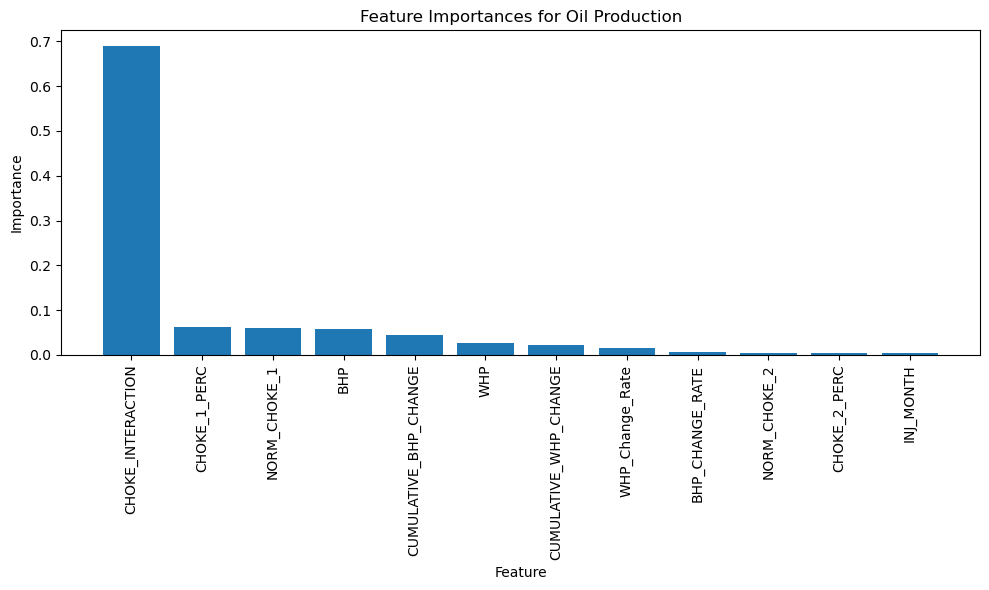

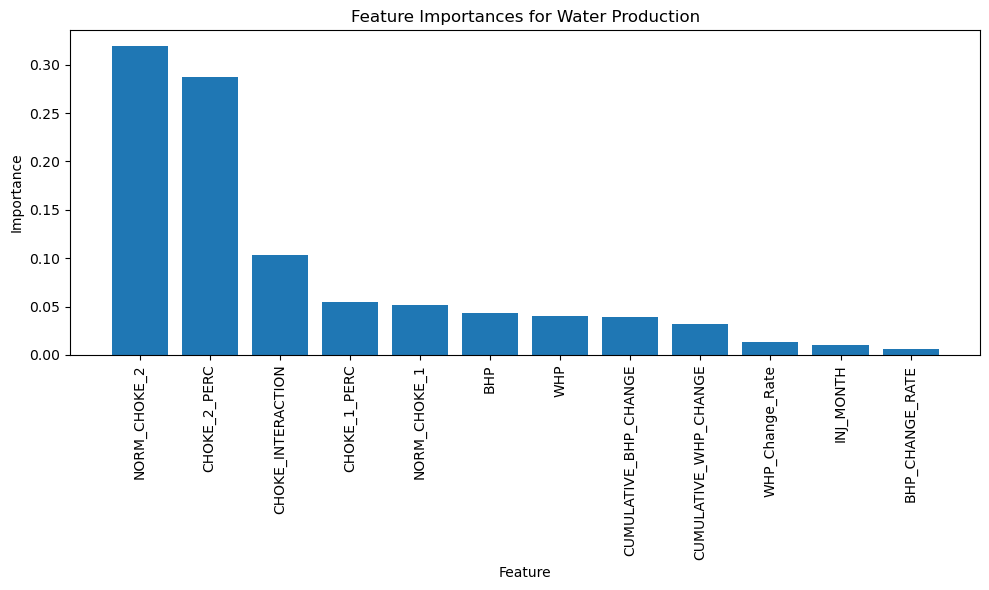

In [29]:
plot_feature_importances(regressor_oil, selected_features_oil_rf, 'Feature Importances for Oil Production')
plot_feature_importances(regressor_wat, selected_features_wat_rf, 'Feature Importances for Water Production')

- The model identifies that the best split for oil production is choke interaction and for water production as watercut 
- this could probably be happening as our model is nearing the end of its life cycle

**inspecting feature importance with shap values**

In [45]:
def generate_shap_values(regressor, X_val):
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_val)
    return explainer, shap_values

def plot_summary(shap_values, X_val):
    shap.summary_plot(shap_values, X_val)

def plot_waterfalls(explainer, shap_values, X_val, y_val, prediction, num_instances=10):
    errors = np.abs(y_val - prediction)
    most_incorrect_indices = np.argsort(errors)[-num_instances:]
    for idx in most_incorrect_indices:
        shap_values_instance = shap.Explanation(values=shap_values[idx],
                                                base_values=explainer.expected_value, 
                                                data=X_val.iloc[idx], 
                                                feature_names=X_val.columns.tolist())
        shap.plots.waterfall(shap_values_instance)

prediction_oil = regressor_oil.predict(X_val_oil)
prediction_wat = regressor_wat.predict(X_val_wat)

X_train_oil, X_val_oil, y_train_oil, y_val_oil = train_test_split(data[selected_features_oil_rf], data['OIL_PROD'], test_size=0.2, random_state=42)
X_train_wat, X_val_wat, y_train_wat, y_val_wat = train_test_split(data[selected_features_wat_rf], data['WAT_PROD'], test_size=0.2, random_state=42)

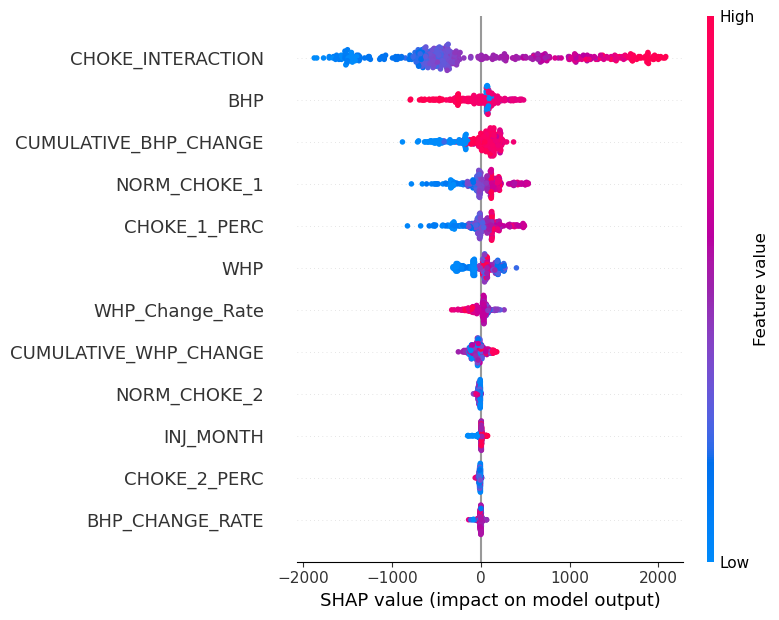

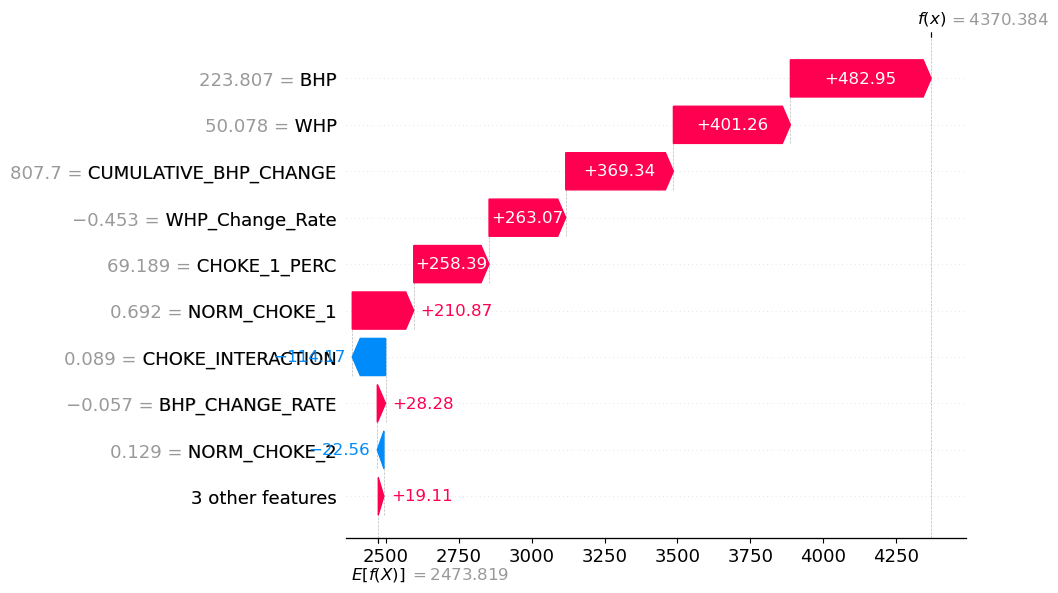

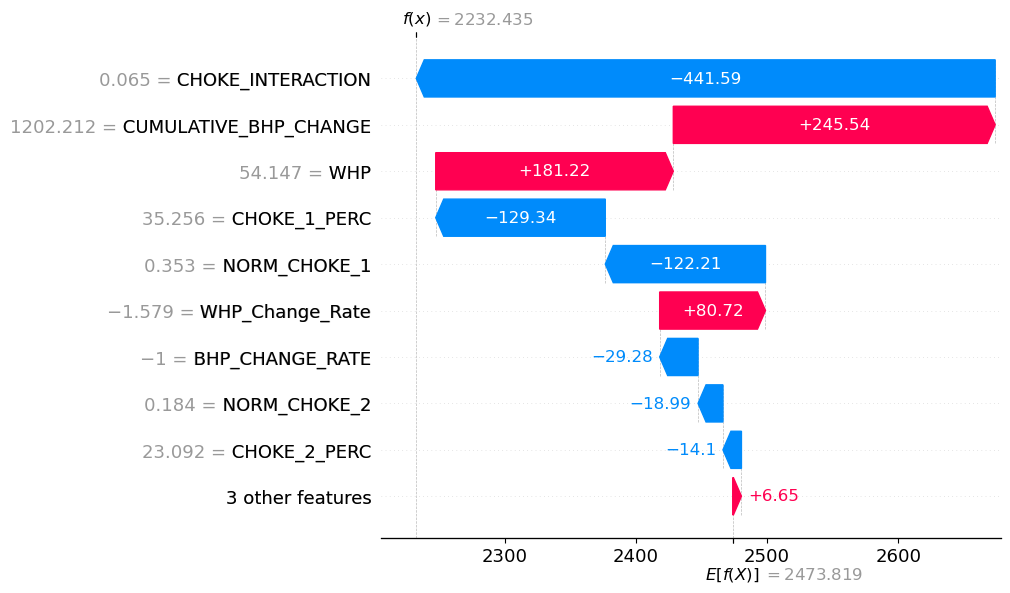

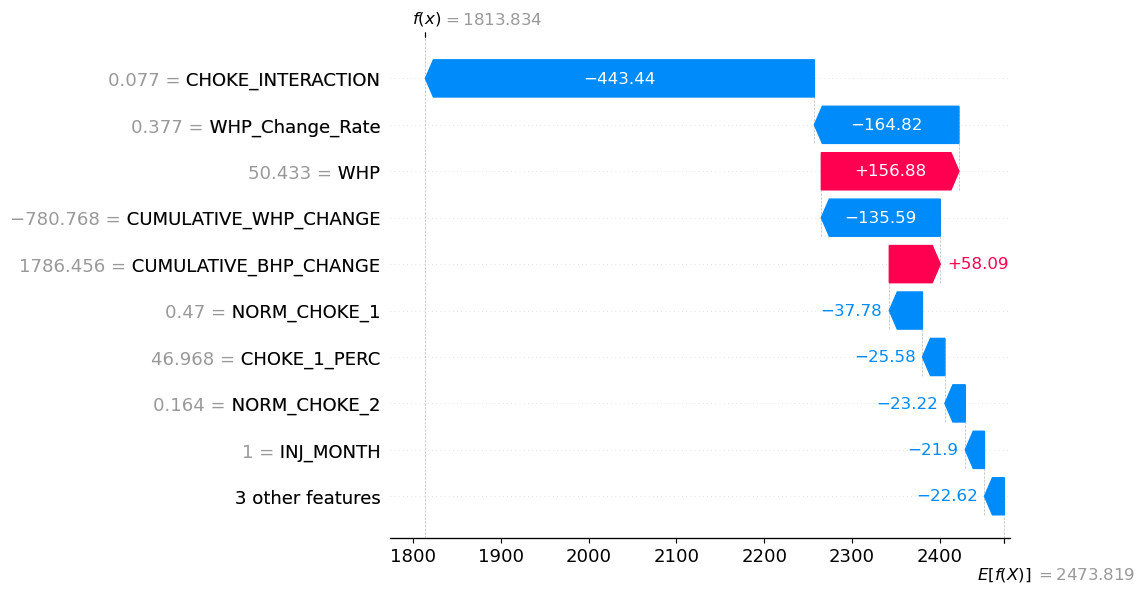

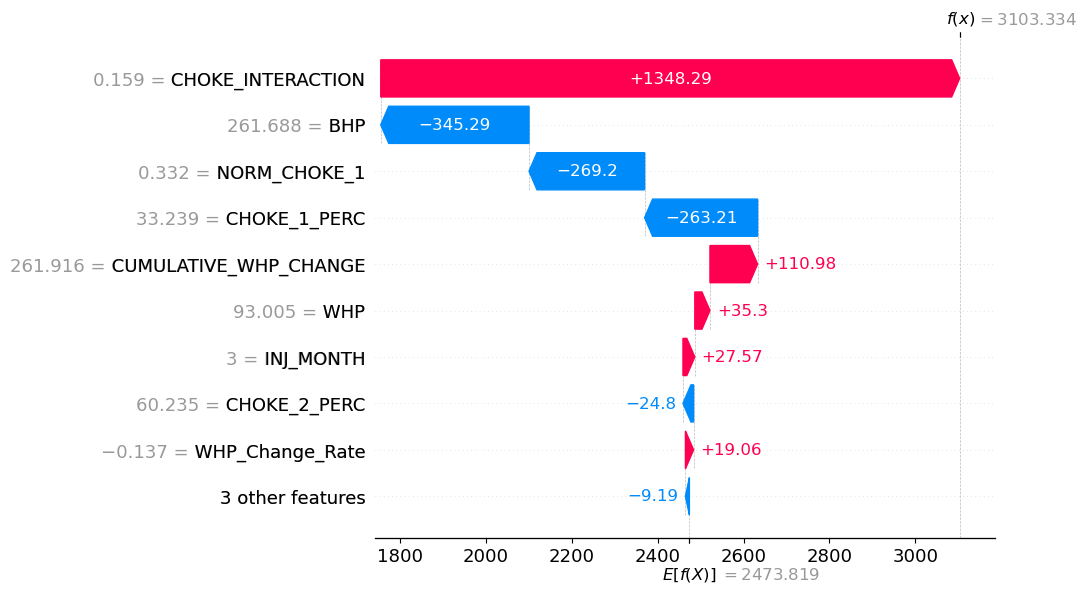

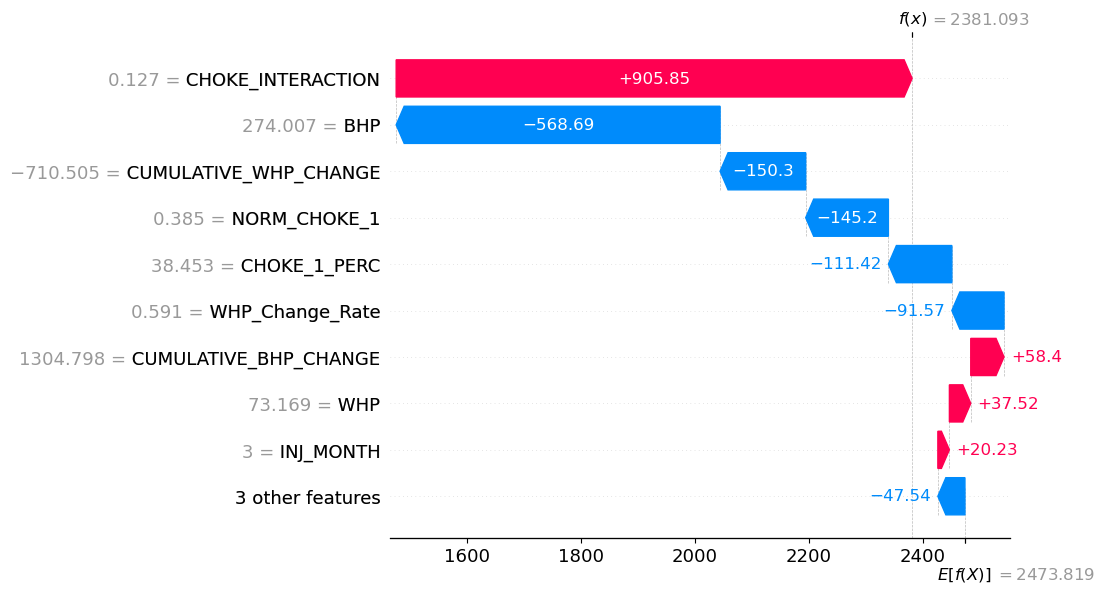

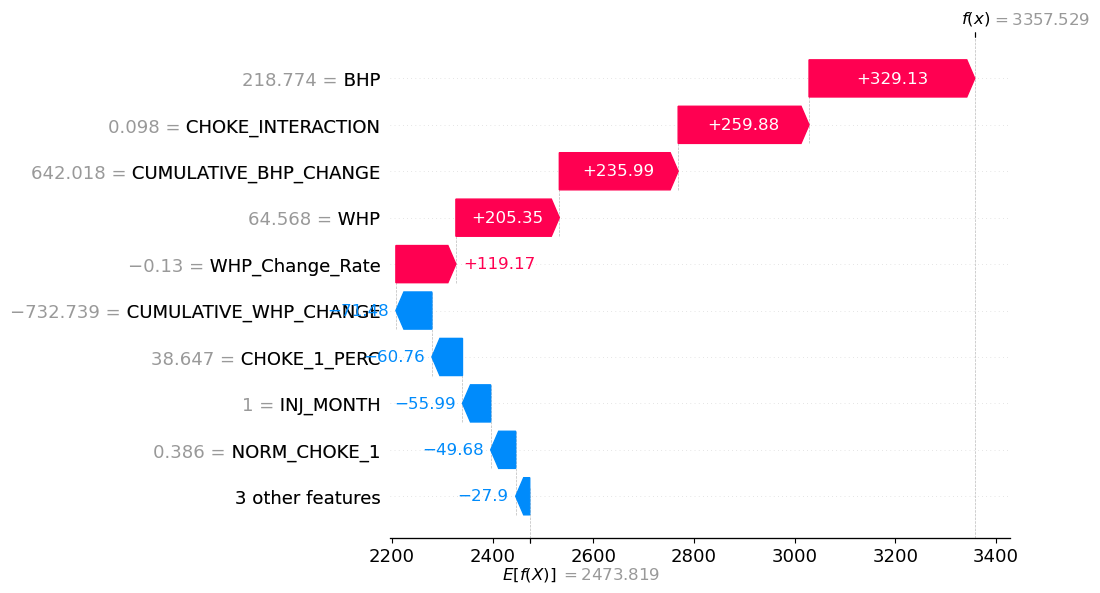

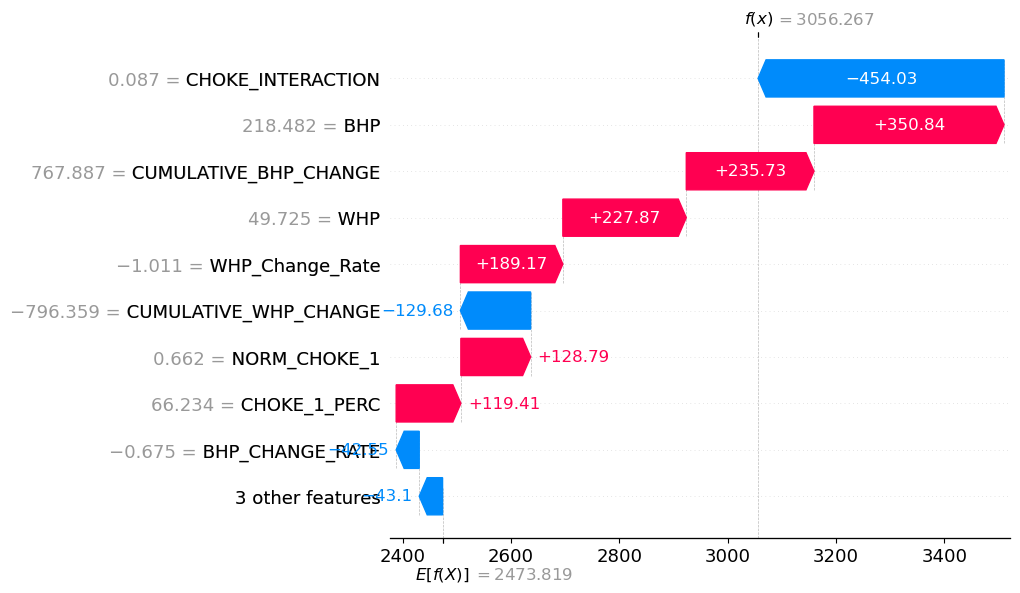

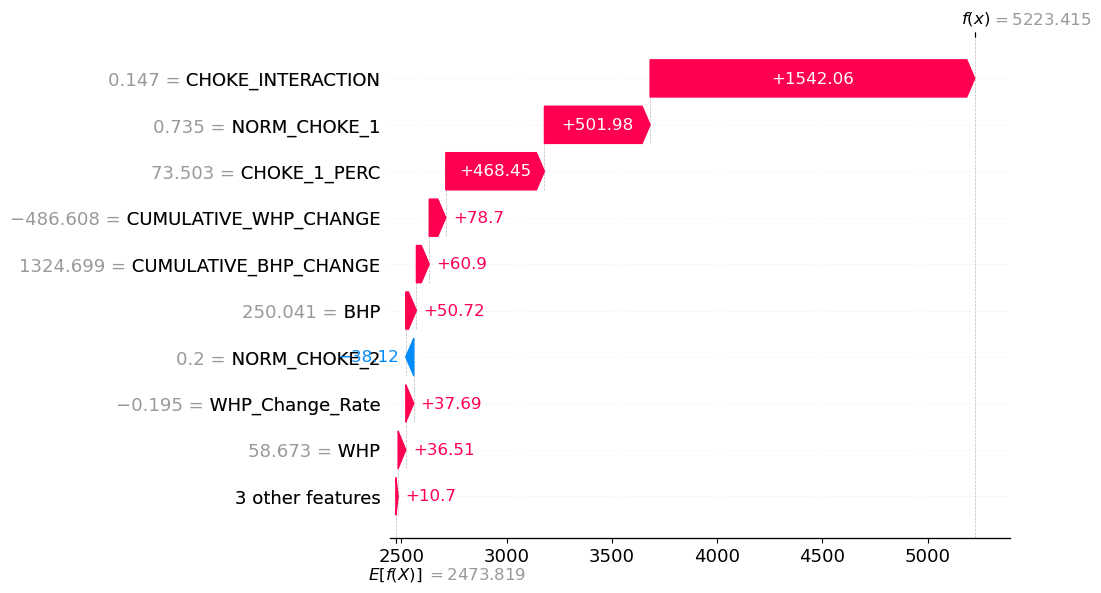

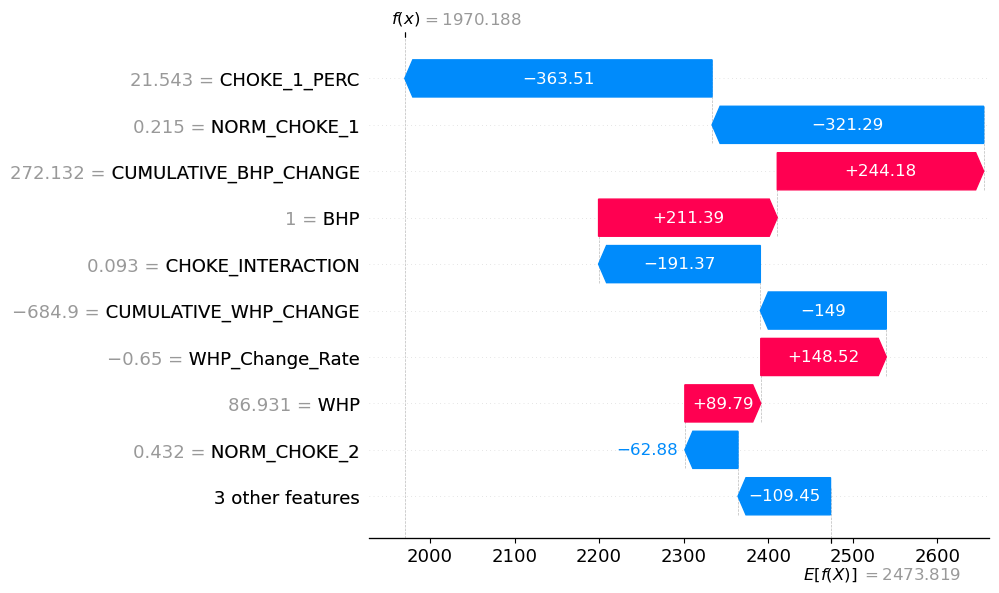

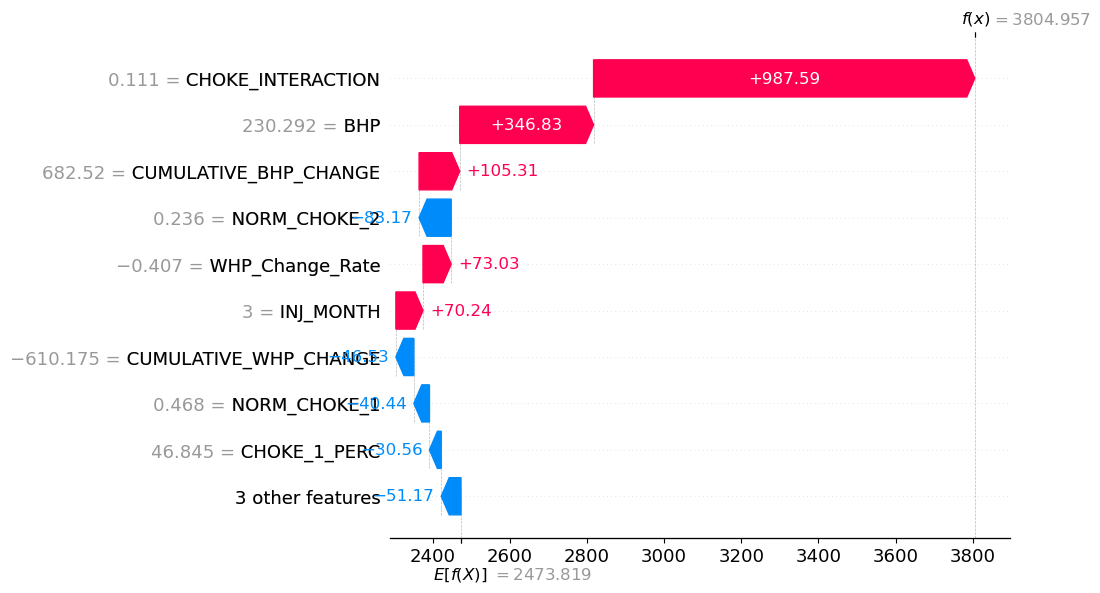

In [46]:
# SHAP values oil
explainer_oil = shap.TreeExplainer(regressor_oil)
shap_values_oil = explainer_oil.shap_values(X_val_oil)

shap.summary_plot(shap_values_oil, X_val_oil)

#incorrect indices
errors = np.abs(y_val_oil - prediction_oil)
most_incorrect_indices = np.argsort(errors)[-10:]

for idx in most_incorrect_indices:
    shap_values_instance = shap.Explanation(values=shap_values_oil[idx],
                                            base_values=explainer_oil.expected_value, 
                                            data=X_val_oil.iloc[idx], 
                                            feature_names=X_val_oil.columns.tolist())
    shap.plots.waterfall(shap_values_instance)

- the summary plot shows choke interaction as important feature.Usually lower values of choke interaction show low impact on predictions, although there are few outliers
- higher value of watercut has lower impact on these values
- the above code also filters out instances for the top 10 incorrectly classified examples by absolute error
- Although the primary driver oil seems to be choke iteraction for oil production production,watercut,cumalative BHP seems to impact these decison more.
- also injection months seems to be a driving factor in some instances.which may suggest that we would need to time series approaches as well,as the well may be reaching saturation.

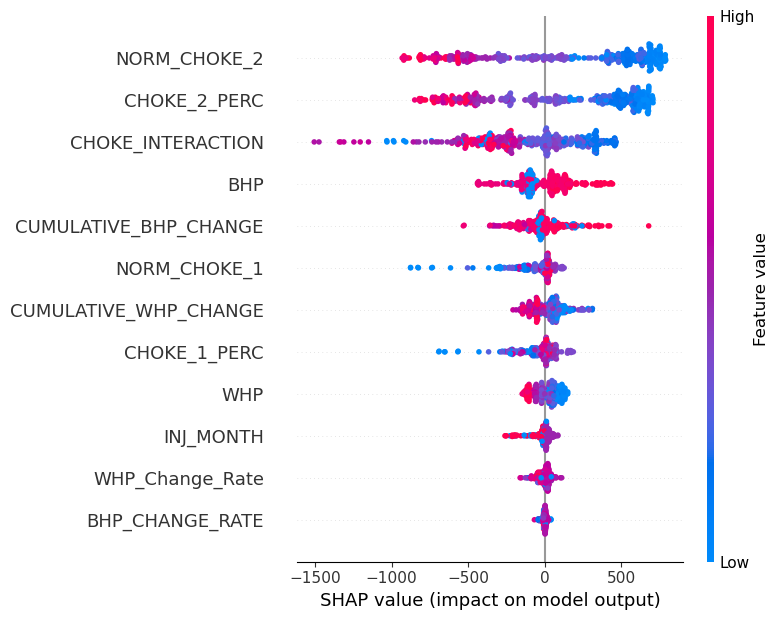

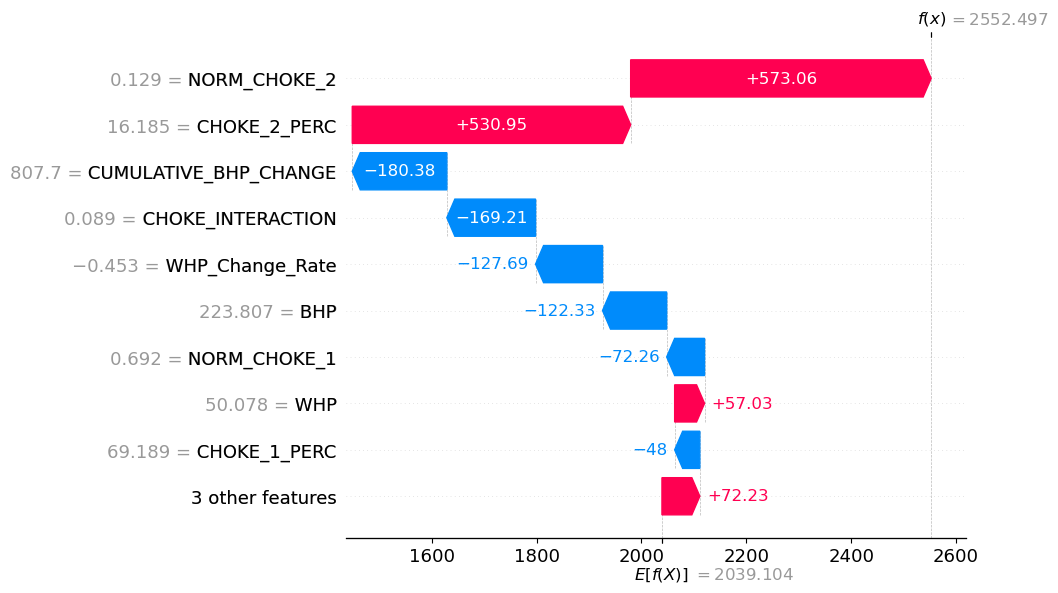

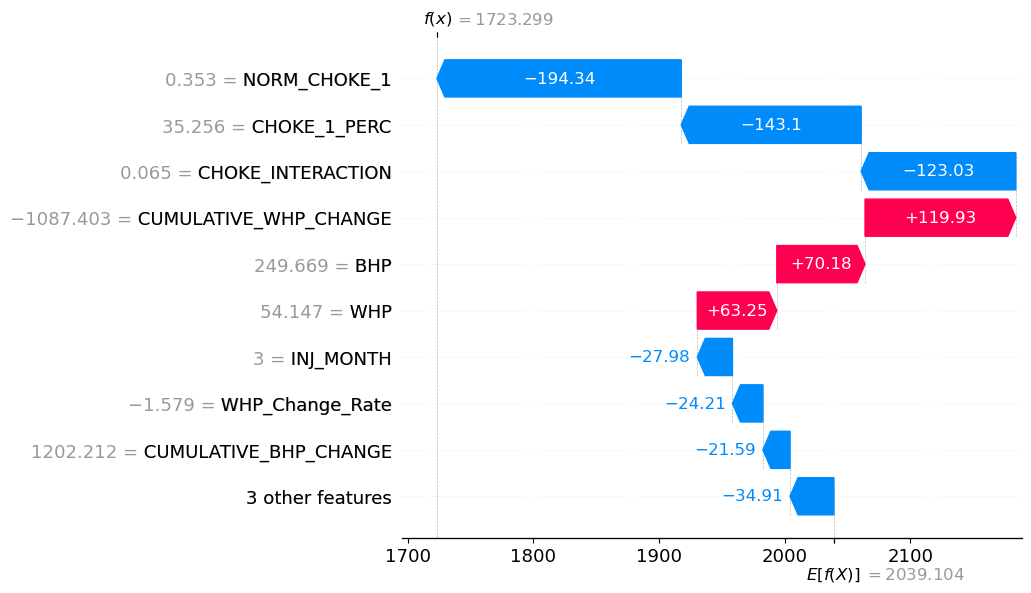

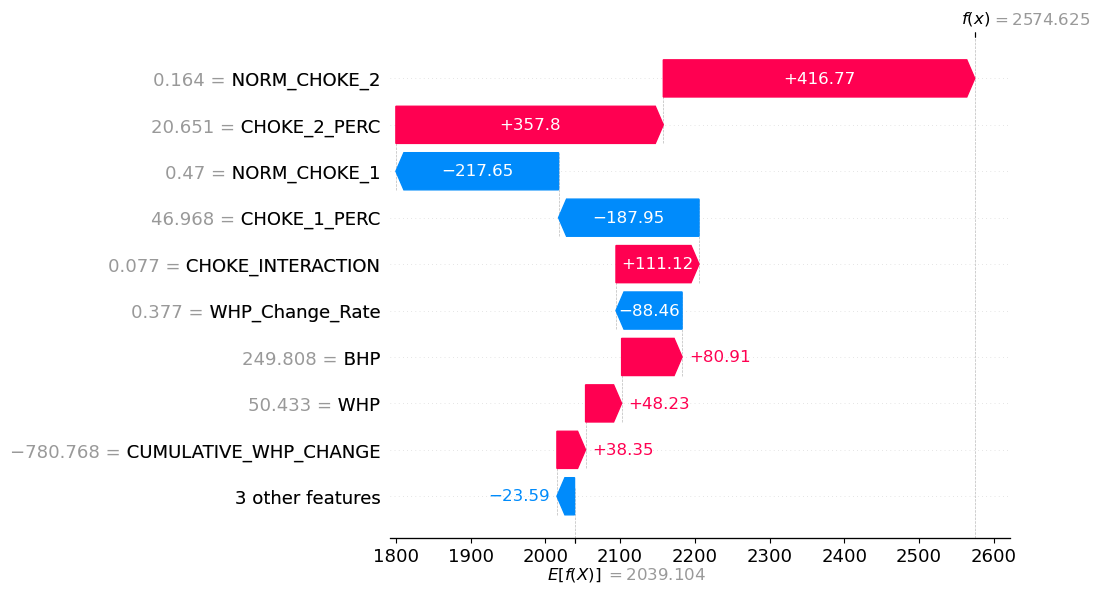

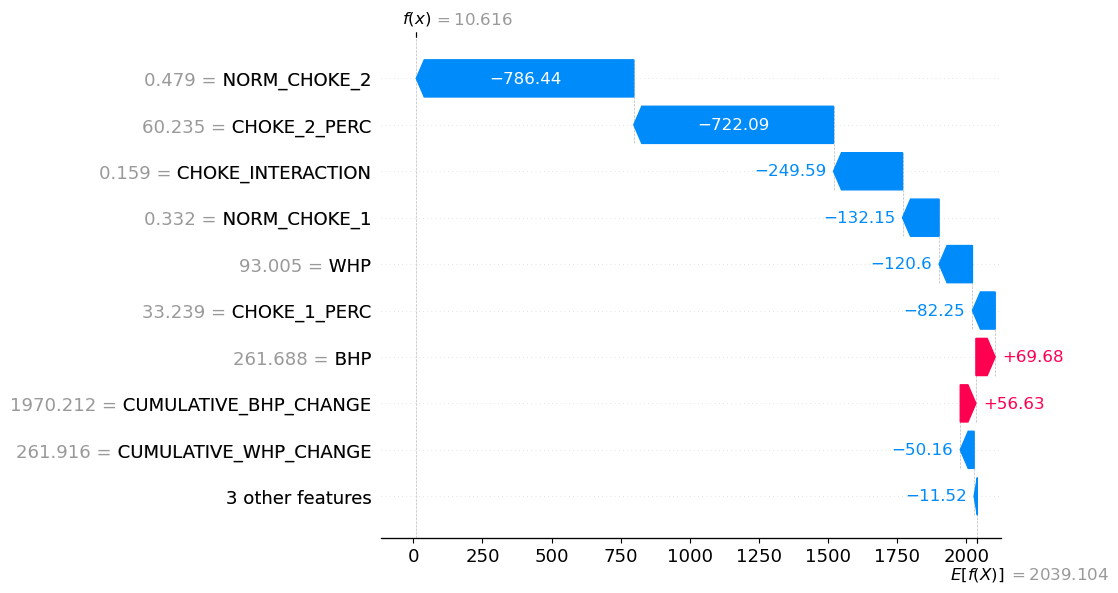

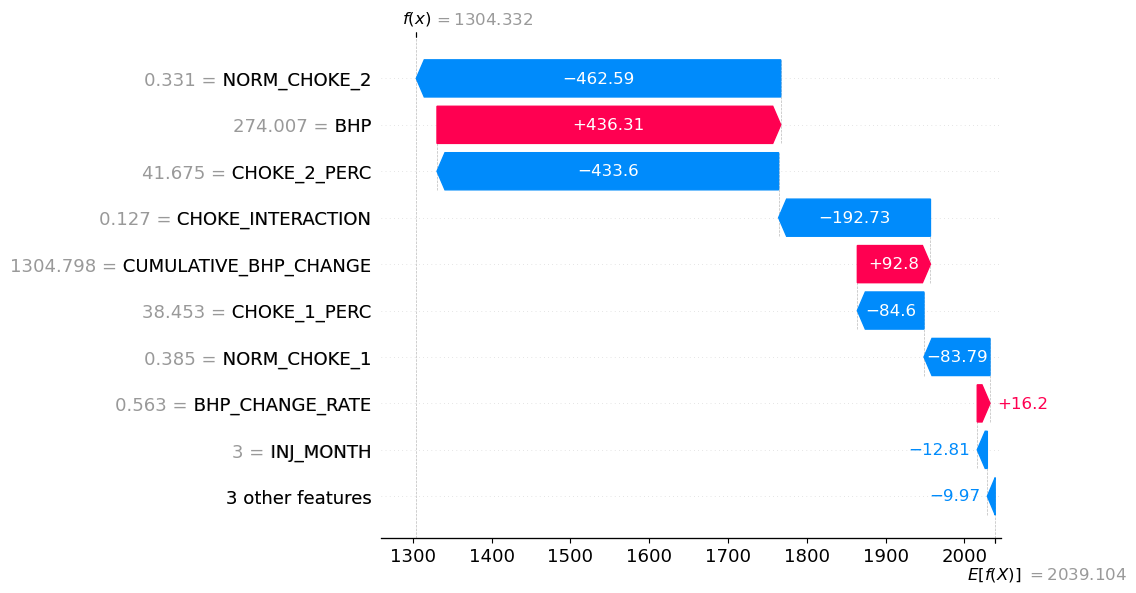

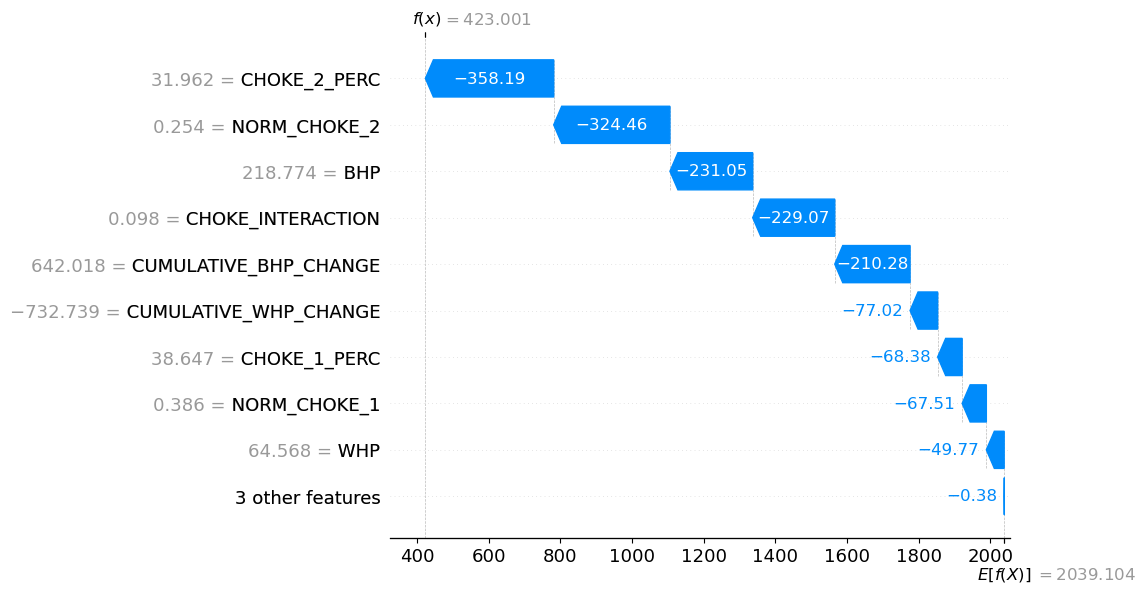

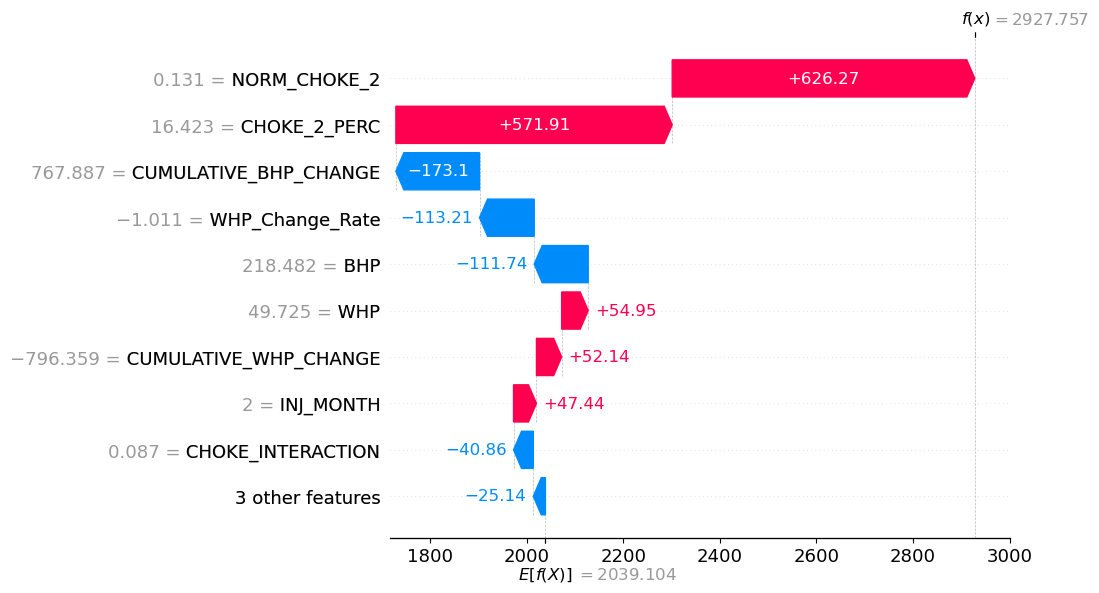

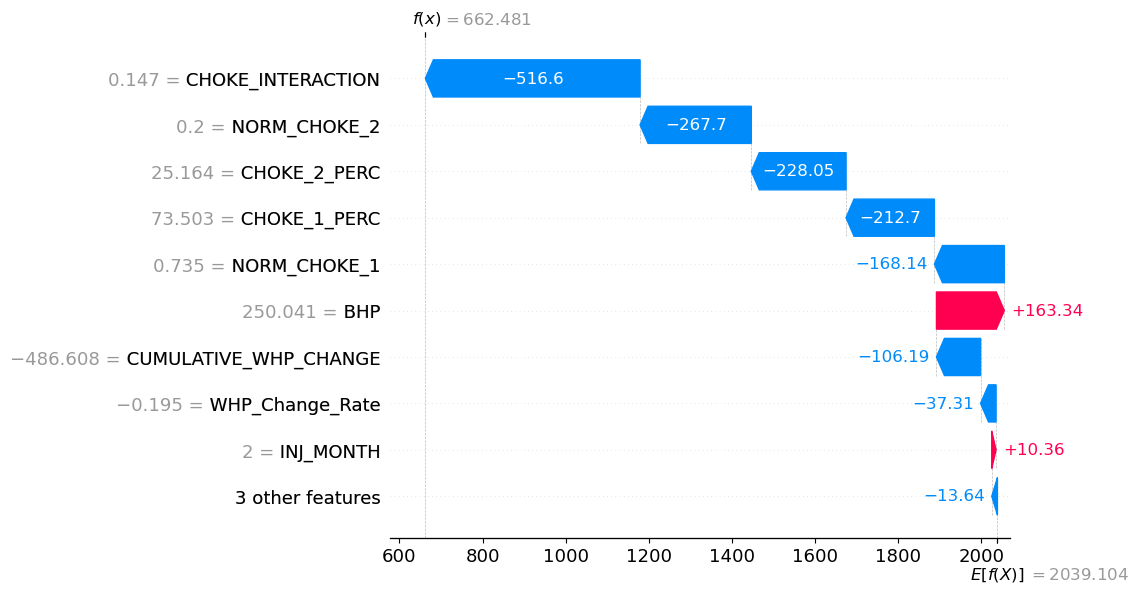

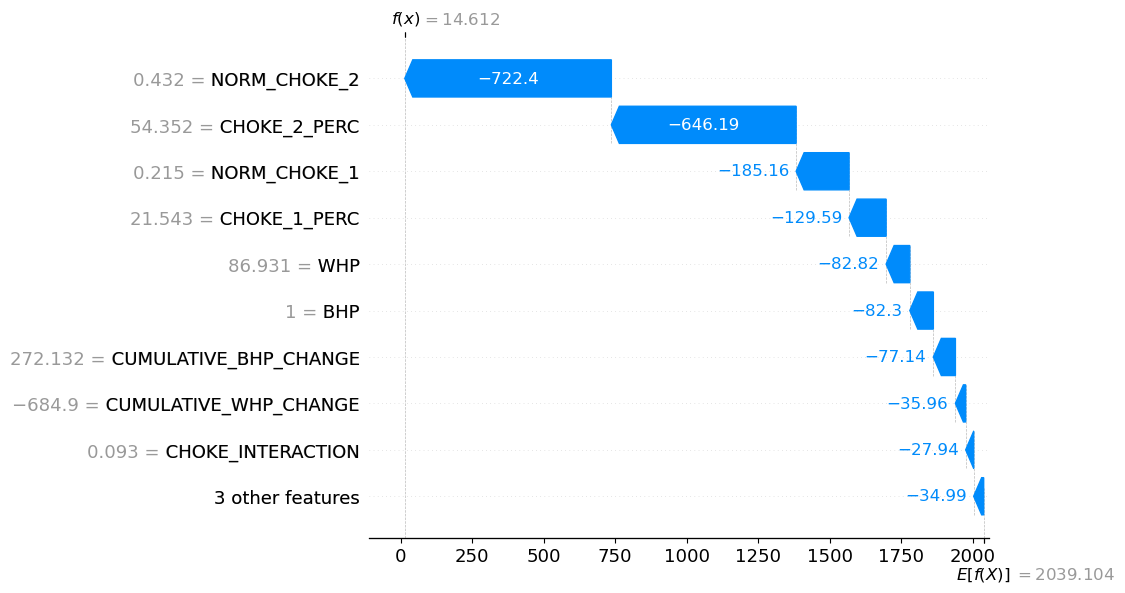

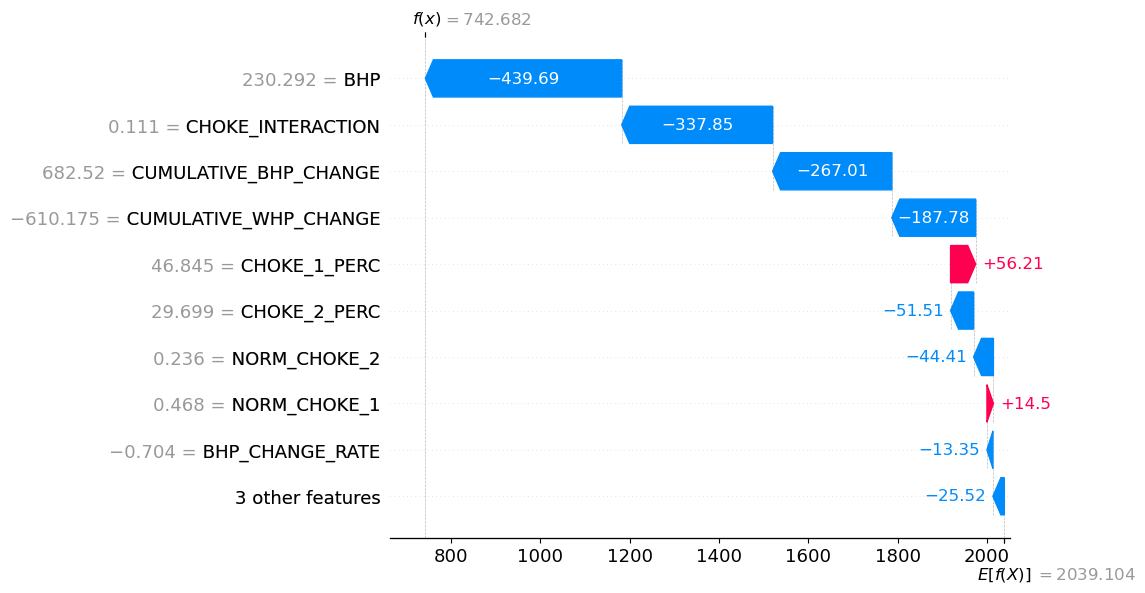

In [47]:
# SHAP values water
explainer_wat = shap.TreeExplainer(regressor_wat)
shap_values_wat = explainer_wat.shap_values(X_val_wat)

shap.summary_plot(shap_values_wat, X_val_wat)

#incorrect indices
errors = np.abs(y_val_oil - prediction_oil)
most_incorrect_indices = np.argsort(errors)[-10:]

for idx in most_incorrect_indices:
    shap_values_instance = shap.Explanation(values=shap_values_wat[idx],
                                            base_values=explainer_wat.expected_value, 
                                            data=X_val_oil.iloc[idx], 
                                            feature_names=X_val_wat.columns.tolist())
    shap.plots.waterfall(shap_values_instance)

- The primary driver water production seems to be choke 2 openess . Misclassified examples mostly exist because of change in BHP and WHP over time. these happen during medium and high injection months 

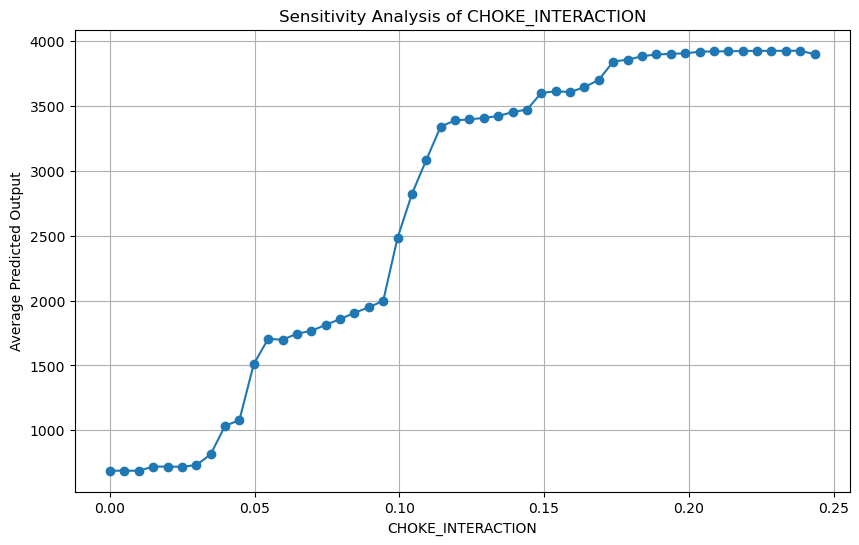

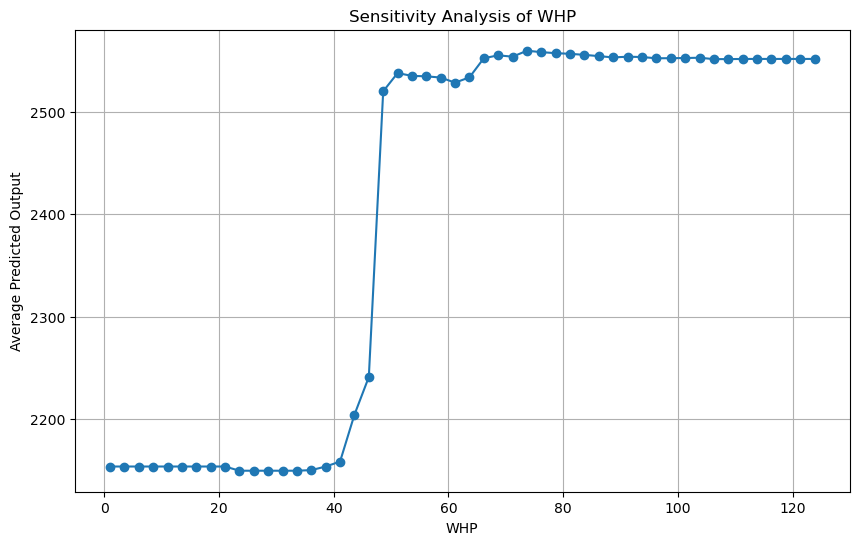

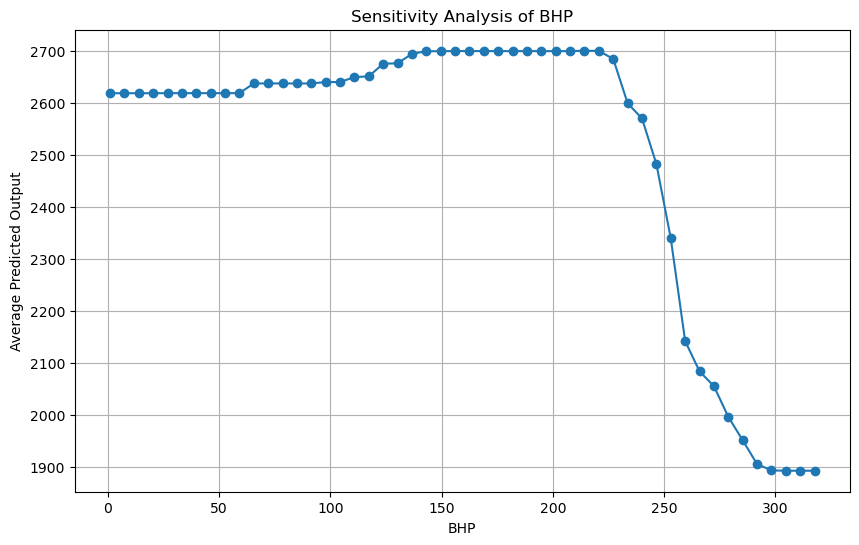

In [37]:
# senstivity oil
sensitivity_analyzer = SensitivityAnalysis(regressor_oil)

# For local sensitivity analysis on CHOKE_INTERACTION 
feature = 'CHOKE_INTERACTION'
feature_range = np.linspace(start=min(X_val_oil[feature]), stop=max(X_val_oil[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_oil, feature, feature_range)
# For local sensitivity analysis on WHP 
feature = 'WHP'
feature_range = np.linspace(start=min(X_val_oil[feature]), stop=max(X_val_oil[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_oil, feature, feature_range)
# For local sensitivity analysis on BHP 
feature = 'BHP'
feature_range = np.linspace(start=min(X_val_oil[feature]), stop=max(X_val_oil[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_oil, feature, feature_range)

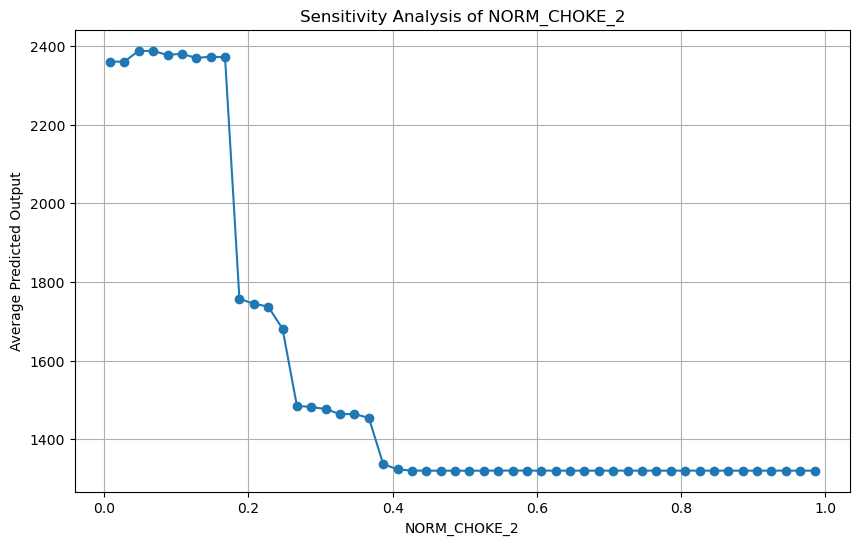

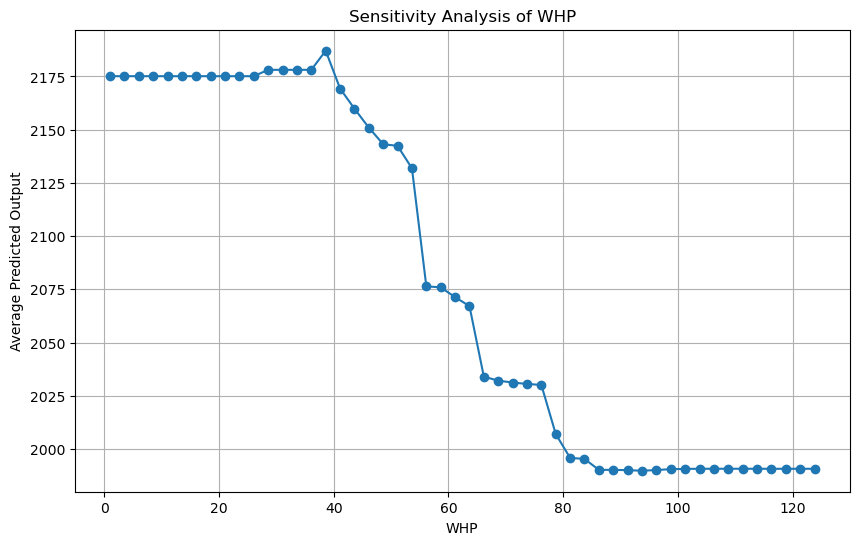

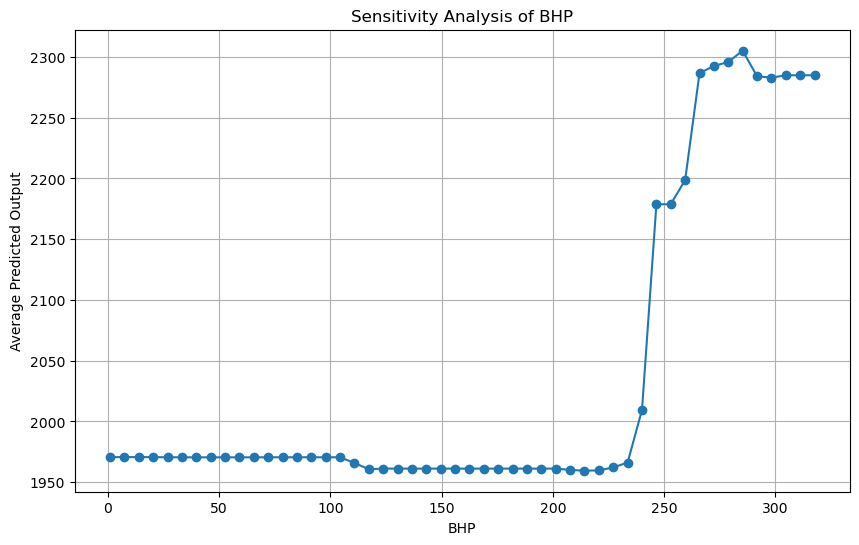

In [38]:
# senstivity wat
sensitivity_analyzer = SensitivityAnalysis(regressor_wat)
# For local sensitivity analysis on a specific feature

feature = 'NORM_CHOKE_2'
feature_range = np.linspace(start=min(X_val_wat[feature]), stop=max(X_val_wat[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_wat, feature, feature_range)
feature = 'WHP'
feature_range = np.linspace(start=min(X_val_wat[feature]), stop=max(X_val_wat[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_wat, feature, feature_range)
feature = 'BHP'
feature_range = np.linspace(start=min(X_val_wat[feature]), stop=max(X_val_wat[feature]), num=50)
feature_range, predictions = sensitivity_analyzer.local_sensitivity_analysis(X_val_wat, feature, feature_range)

- model prediction outcome for our seems to increase rapidly around choke interaction of 0.5, then go up again at choke interaction of 0.15 for oil production
- model prediction seems fine with BHP but shows high variation with WHP, therefore we can further explore the interaction effects here.

## Model Limitations and Further Explorations

- High importance doesn't imply causality but rather a strong association used by the model for predictions
- There were instances where BHP was 1 and oil was still produced,and if these instances were incorrect, Random Forest although robust but can still overfit especially in the presence of noise.
- The results here was based on random subset of data, but we also need to account for anomalies and outlier events that may be occuring.A better curated test on these instances will provides a better genralisation
- Interaction Effects: Beyond individual feature importance, exploring interaction effects between features can provide deeper insights
- Time series approaches: our model found watercut and injection over time to be important factors.This could mean that oil well is nearing its end.We could try time series models like arima,LSTM to better capture temporal variance.
- Based on Senstivity analysis and shap plots for incorrectly identified instances,we can further investigate feature an repeat the process

In [39]:
test_data = processor.prepare_data('data/prod_data_test_CANDIDATE.csv')
test_data = process_data(test_data, max_choke_1_train, max_choke_2_train)

In [40]:
production_part = test_data[test_data.WELLNAME.isin([5351, 5599])]

In [42]:
production_part.loc[:, 'OIL_PROD'] = regressor_oil.predict(production_part[selected_features_oil_rf])
production_part.loc[:, 'WAT_PROD'] = regressor_wat.predict(production_part[selected_features_wat_rf])

In [43]:
name = 'Luve'
production_part.to_csv('%s_prediction.csv'%name, index=None)